# **Satisfaction Analysis**

## Imports

In [27]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
import seaborn as sns
import pandas as pd

## Démarrage Spark Session et récupération dataset

In [28]:
# Initialiser SparkSession
spark = SparkSession.builder \
        .appName("Airline Satisfaction Analysis") \
        .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
# Récupération des données
df = spark.read.csv('dataset/Airline_customer_satisfaction.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- satisfaction: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- Online support: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Cleanliness: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Departure Delay in Minutes: inte

## **0. Analyse générale**

In [52]:
df_pd = df.toPandas()
df_pd.head(10)

satisfaction   Customer Type  Age   Type of Travel     Class  \
0    satisfied  Loyal Customer   65  Personal Travel       Eco   
1    satisfied  Loyal Customer   47  Personal Travel  Business   
2    satisfied  Loyal Customer   15  Personal Travel       Eco   
3    satisfied  Loyal Customer   60  Personal Travel       Eco   
4    satisfied  Loyal Customer   70  Personal Travel       Eco   
5    satisfied  Loyal Customer   30  Personal Travel       Eco   
6    satisfied  Loyal Customer   66  Personal Travel       Eco   
7    satisfied  Loyal Customer   10  Personal Travel       Eco   
8    satisfied  Loyal Customer   56  Personal Travel  Business   
9    satisfied  Loyal Customer   22  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   
5             1894             0                                  0   
6              227             0                                  0   
7             1812             0                                  0   
8               73             0                                  0   
9             1556             0                                  0   

   Food and drink  Gate location  ...  Online support  Ease of Online booking  \
0               0              2  ...               2                       3   
1               0              3  ...               2                       3   
2               0              3  ...               2                       2   
3               0              3  ...               3                       1   
4               0              3  ...               4                       2   
5               0              3  ...               2                       2   
6               0              3  ...               5                       5   
7               0              3  ...               2                       2   
8               0              3  ...               5                       4   
9               0              3  ...               2                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   
5                 5                 4                 5                5   
6                 5                 0                 5                5   
7                 3                 3                 4                5   
8                 4                 0                 1                5   
9                 2                 4                 5                3   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   
5            4                2                           0   
6            5                3                          17   
7            4                2                           0   
8            4                4                           0   
9            4                2                          30   

   Arrival Delay in Minutes  
0                       0.0  
1         

### Les valeurs uniques pour chaques colonnes

In [4]:
categorical_columns = ['satisfaction', 'Customer Type', 'Type of Travel', 'Class']

# Afficher les valeurs distinctes pour chaque colonne catégorielle
for column in categorical_columns:
    unique_values = df_pd[column].unique()
    print(f"Valeurs distinctes pour la colonne '{column}':")
    print(unique_values)
    print()

Valeurs distinctes pour la colonne 'satisfaction':
['satisfied' 'dissatisfied']

Valeurs distinctes pour la colonne 'Customer Type':
['Loyal Customer' 'disloyal Customer']

Valeurs distinctes pour la colonne 'Type of Travel':
['Personal Travel' 'Business travel']

Valeurs distinctes pour la colonne 'Class':
['Eco' 'Business' 'Eco Plus']



### Répartition des classes pour chaque colonnes

/tmp/ipykernel_1322407/1877820267.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pd, x=column, ax=axes[idx], palette='viridis')
/tmp/ipykernel_1322407/1877820267.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pd, x=column, ax=axes[idx], palette='viridis')
/tmp/ipykernel_1322407/1877820267.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_pd, x=column, ax=axes[idx], palette='viridis')
/tmp/ipykernel_1322407/1877820267.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

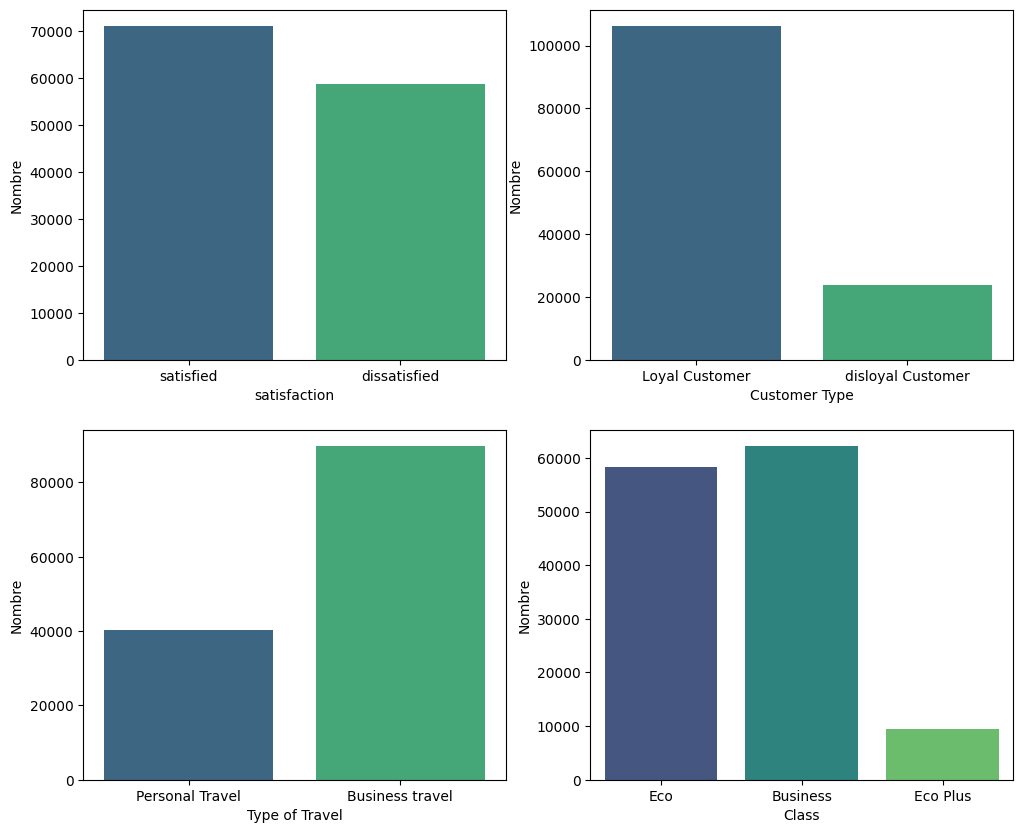

In [30]:
num_plots = len(categorical_columns)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() 

for idx, column in enumerate(categorical_columns):
    sns.countplot(data=df_pd, x=column, ax=axes[idx], palette='viridis')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Nombre')

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.show()

In [37]:
rating_columns = [
    'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink',
    'Gate location', 'Online support', 'Ease of Online booking', 'On-board service',
    'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness',
    'Online boarding'
]

mean_ratings = df_pd[rating_columns].mean()

mean_ratings_sorted = mean_ratings.sort_values(ascending=True)

print("Moyennes des notes pour chaque critère:")
print(mean_ratings_sorted)

Moyennes des notes pour chaque critère:
Seat comfort                         2.838597
Food and drink                       2.851994
Gate location                        2.990422
Departure/Arrival time convenient    2.990645
Checkin service                      3.340807
Online boarding                      3.352587
On-board service                     3.465075
Ease of Online booking               3.472105
Leg room service                     3.485902
Online support                       3.519703
Baggage handling                     3.695673
Cleanliness                          3.705759
dtype: float64


In [34]:
# Calculer l'écart-type pour chaque colonne pertinente
std_devs = df_pd[rating_columns].std()

# Afficher les écarts-types
print("Écart-type des notes pour chaque critère :")
print(std_devs)

Écart-type des notes pour chaque critère :
Seat comfort                         1.392983
Departure/Arrival time convenient    1.527224
Food and drink                       1.443729
Gate location                        1.305970
Online support                       1.306511
Ease of Online booking               1.305560
On-board service                     1.270836
Leg room service                     1.292226
Baggage handling                     1.156483
Checkin service                      1.260582
Cleanliness                          1.151774
Online boarding                      1.298715
dtype: float64


In [36]:
# Calculer l'écart-type pour chaque colonne pertinente
std_devs = df_pd[rating_columns].var()

# Afficher les écarts-types
print("Variances des notes pour chaque critère :")
print(std_devs)

Variances des notes pour chaque critère :
Seat comfort                         1.940402
Departure/Arrival time convenient    2.332414
Food and drink                       2.084355
Gate location                        1.705557
Online support                       1.706970
Ease of Online booking               1.704486
On-board service                     1.615023
Leg room service                     1.669848
Baggage handling                     1.337454
Checkin service                      1.589068
Cleanliness                          1.326583
Online boarding                      1.686659
dtype: float64


/tmp/ipykernel_1322407/2084325559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_ratings_sorted.values, y=mean_ratings_sorted.index, palette='RdYlGn')


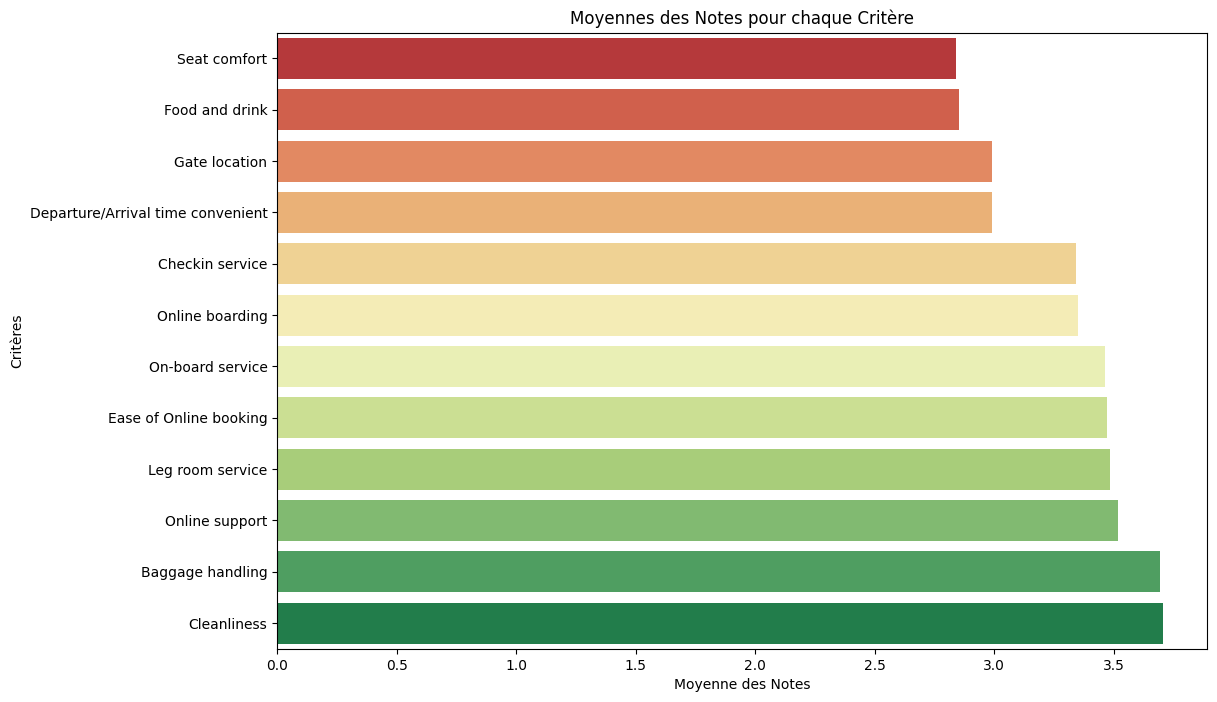

In [38]:
plt.figure(figsize=(12, 8))
sns.barplot(x=mean_ratings_sorted.values, y=mean_ratings_sorted.index, palette='RdYlGn')
plt.title('Moyennes des Notes pour chaque Critère')
plt.xlabel('Moyenne des Notes')
plt.ylabel('Critères')
plt.show()

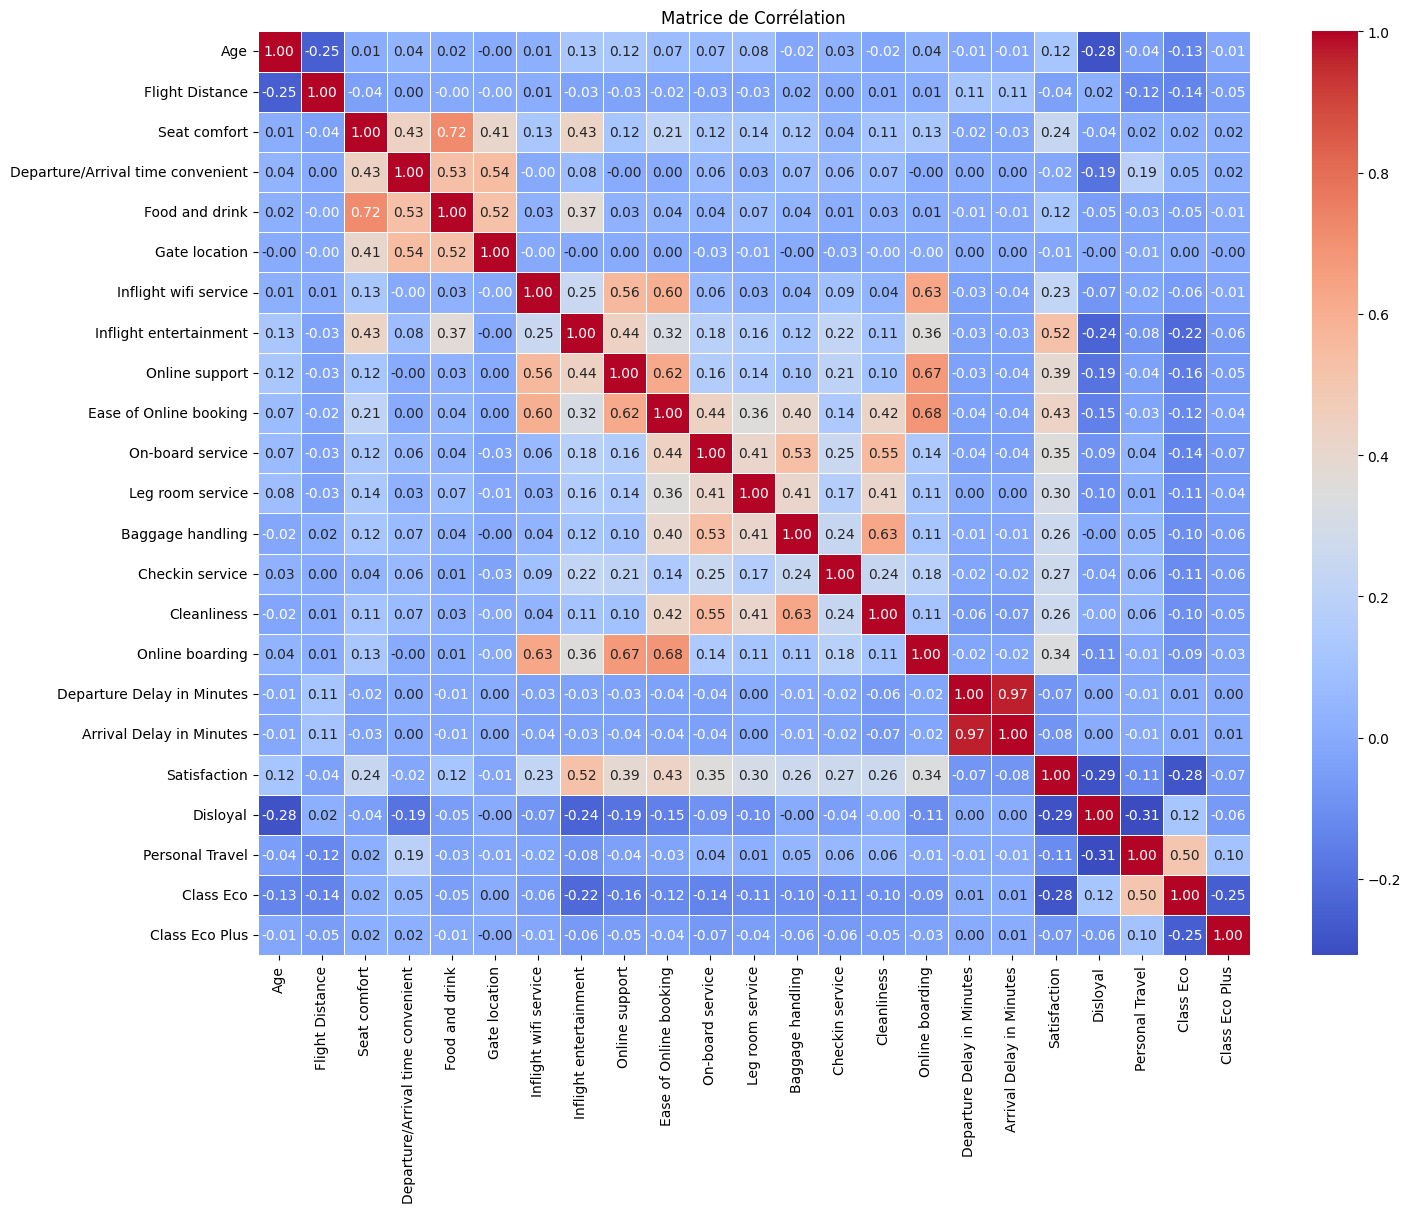

In [32]:
df_encoded = pd.get_dummies(df_pd, columns=categorical_columns, drop_first=True)
df_encoded = df_encoded.rename(columns = {
    'satisfaction_satisfied' : 'Satisfaction',
    'Customer Type_disloyal Customer' : 'Disloyal',
    'Type of Travel_Personal Travel' : 'Personal Travel',
    'Class_Eco' : 'Class Eco',
    'Class_Eco Plus' : 'Class Eco Plus'
})

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

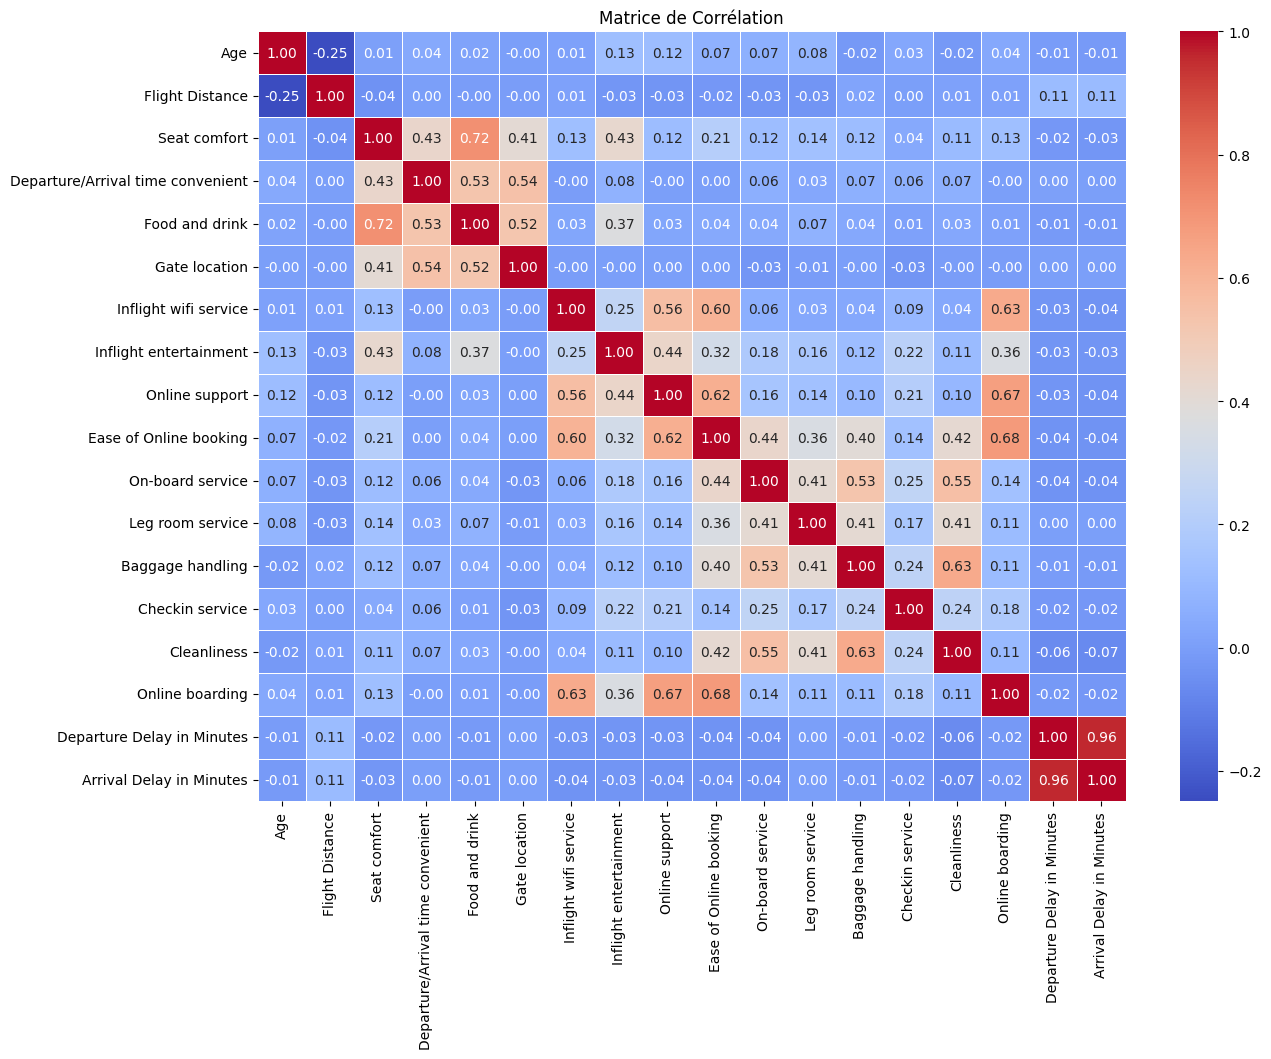

In [26]:
# correlation_matrix = df_pd[rating_columns].corr()
numeric_cols = [
        'Age', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient',
        'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment',
        'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service',
        'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
        'Departure Delay in Minutes', 'Arrival Delay in Minutes'
    ]

# Convertir la matrice de corrélations en liste de Row
rows = []
for col1 in numeric_cols:
    for col2 in numeric_cols:
        rows.append(Row(col1=col1, col2=col2, correlation=correlation_matrix[col1][col2]))

# Créer un DataFrame PySpark à partir de la liste de Row
correlation_df = spark.createDataFrame(rows)

# # Créer une matrice de corrélation en PySpark
# correlation_matrix = {}
# for col1 in numeric_cols:
#     correlation_matrix[col1] = {}
#     for col2 in numeric_cols:
#         corr_value = df.stat.corr(col1, col2)
#         correlation_matrix[col1][col2] = corr_value

# # Convertir la matrice de corrélation en DataFrame Pandas pour la visualisation
# correlation_df = pd.DataFrame(correlation_matrix)

# # Visualisation avec Seaborn
# plt.figure(figsize=(14, 10))
# sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
# plt.title('Matrice de Corrélation')
# plt.show()

## **1. Répartition de la satisfaction**

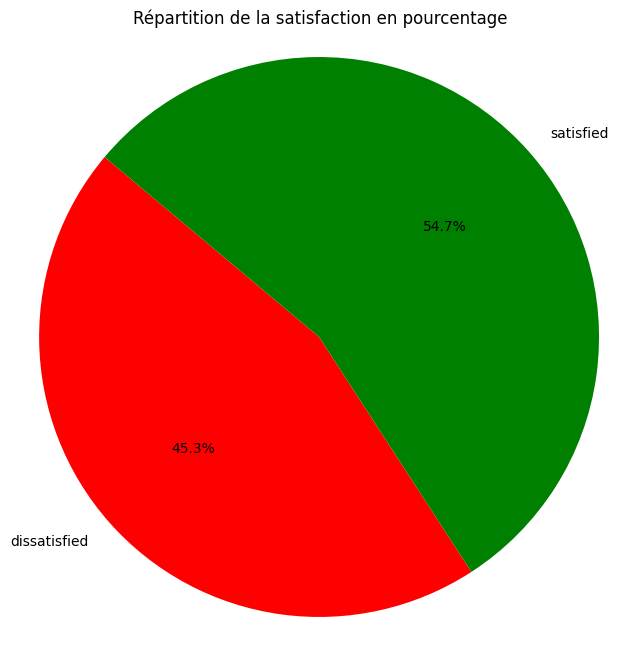

In [10]:
# Distribution de la satisfaction
satisfaction_dist = df.groupBy("satisfaction").count().toPandas()

# Calculer le pourcentage
total_count = satisfaction_dist['count'].sum()
satisfaction_dist['percentage'] = (satisfaction_dist['count'] / total_count) * 100

# Affichage
colors = ['red', 'green']
plt.figure(figsize=(8, 8))
plt.pie(
    satisfaction_dist['percentage'],
    labels=satisfaction_dist['satisfaction'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title("Répartition de la satisfaction en pourcentage")
plt.axis('equal')
plt.show()


## **2. Répartition des types de clients**

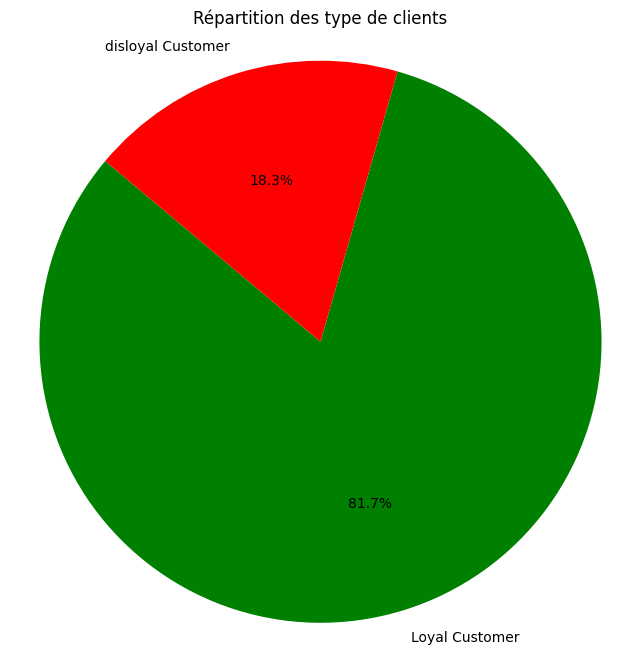

In [11]:
# Distribution des types de clients
customer_type_dist = df.groupBy("Customer Type").count().toPandas()

# Calculer le pourcentage
total_count = customer_type_dist['count'].sum()
customer_type_dist['percentage'] = (customer_type_dist['count'] / total_count) * 100

# Affichage
colors = ['green', 'red']
plt.figure(figsize=(8, 8))
plt.pie(
    customer_type_dist['percentage'],
    labels=customer_type_dist['Customer Type'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title("Répartition des type de clients")
plt.axis('equal')
plt.show()

## **3. Distribution de l'âge**

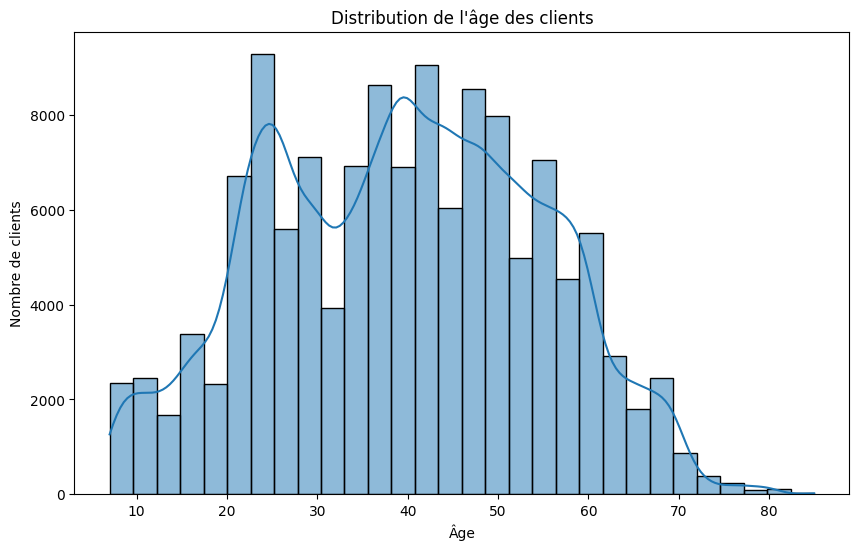

In [12]:
age_dist = df.select("Age").toPandas()

# Afficher l'histogramme de la distribution de l'âge
plt.figure(figsize=(10, 6))
sns.histplot(age_dist['Age'], bins=30, kde=True)
plt.title("Distribution de l'âge des clients")
plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.show()

## Distribution de la majorité entre 20 et 60 ans

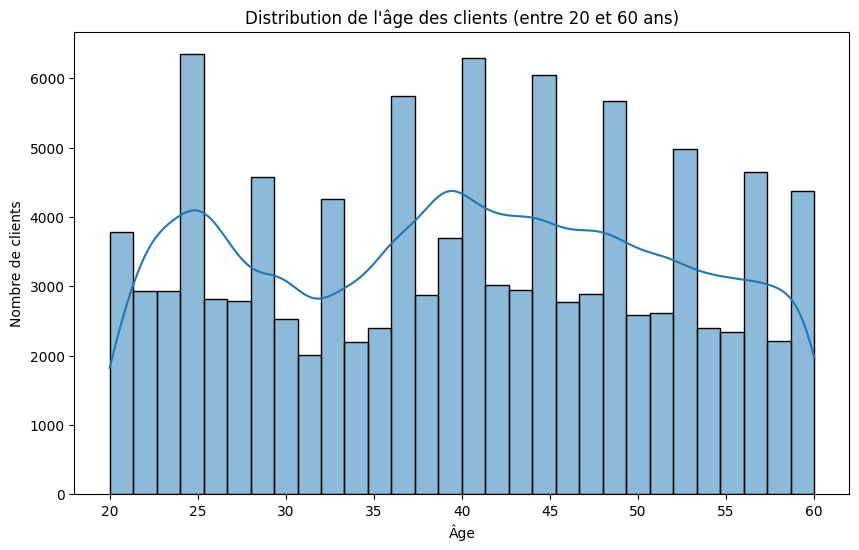

In [30]:
# Filtrer les données pour les âges entre 20 et 60 ans
df_age_filtered = df.filter((df.Age >= 20) & (df.Age <= 60))

# Sélectionner la colonne d'âge et convertir en DataFrame Pandas
age_dist_filtered = df_age_filtered.select("Age").toPandas()

# Afficher l'histogramme de la distribution de l'âge filtré
plt.figure(figsize=(10, 6))
sns.histplot(age_dist_filtered['Age'], bins=30, kde=True)
plt.title("Distribution de l'âge des clients (entre 20 et 60 ans)")
plt.xlabel("Âge")
plt.ylabel("Nombre de clients")
plt.show()

## **4. Répartition satisfaction et type de clients (20 ans - 60 ans)**

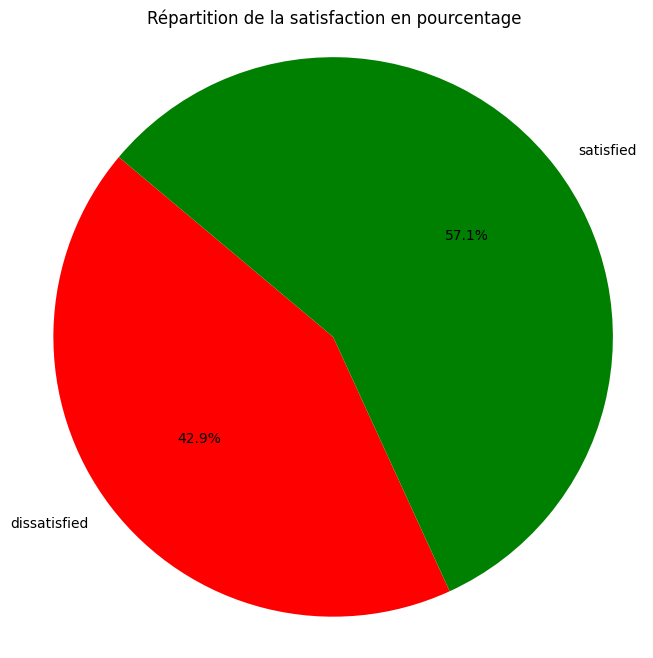

In [14]:
# Répartition de la satisfaction
filtered_satisfaction_dist = df_age_filtered.groupBy("satisfaction").count().toPandas()

# Calculer le pourcentage
total_count = filtered_satisfaction_dist['count'].sum()
filtered_satisfaction_dist['percentage'] = (filtered_satisfaction_dist['count'] / total_count) * 100

# Affichage
colors = ['red', 'green']
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_satisfaction_dist['percentage'],
    labels=filtered_satisfaction_dist['satisfaction'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title("Répartition de la satisfaction en pourcentage")
plt.axis('equal')
plt.show()

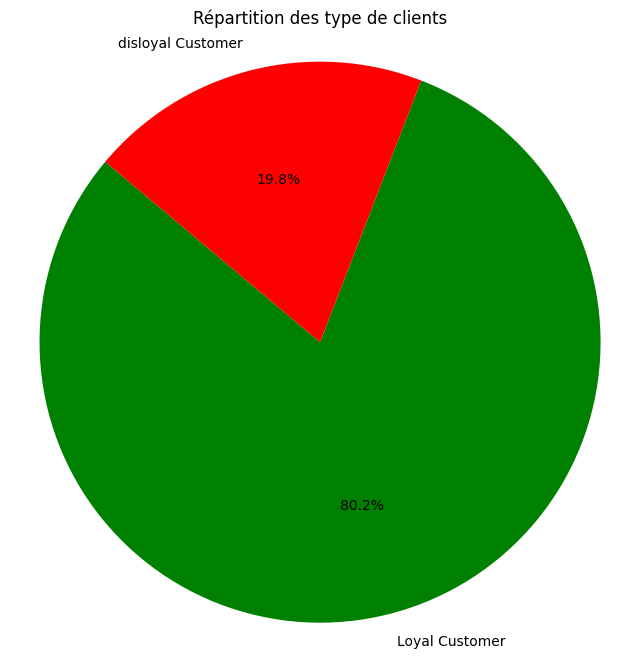

In [15]:
# Répartition des types de clients
filtered_customer_type_dist = df_age_filtered.groupBy("Customer Type").count().toPandas()

# Calculer le pourcentage
total_count = filtered_customer_type_dist['count'].sum()
filtered_customer_type_dist['percentage'] = (filtered_customer_type_dist['count'] / total_count) * 100

# Affichage
colors = ['green', 'red']
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_customer_type_dist['percentage'],
    labels=filtered_customer_type_dist['Customer Type'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title("Répartition des type de clients")
plt.axis('equal')  # Assurer que le graphique est en cercle
plt.show()

## **5. Analyse des clients LOYAUX**

In [31]:
df_loyal = df_age_filtered.filter(df_age_filtered["Customer Type"] == "Loyal Customer")

### 5.1 Satisfaction par **type de voyage**

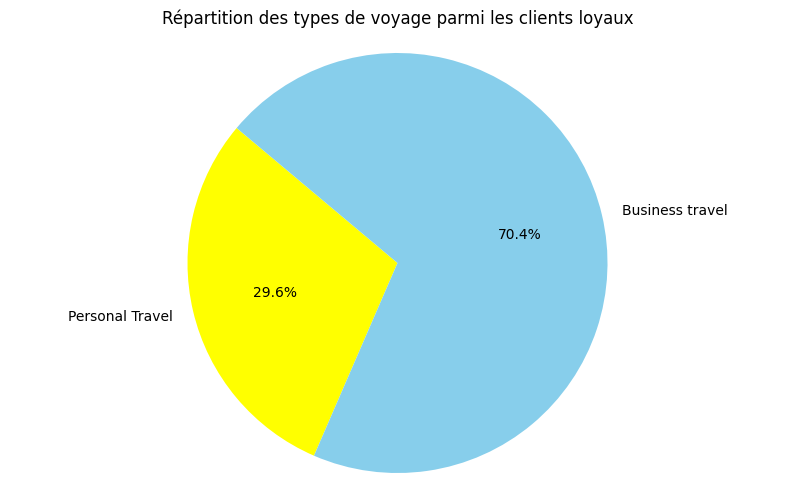

In [13]:
# Grouper par type de voyage
travel_type_dist = df_loyal.groupBy("Type of Travel").count().toPandas()
travel_type_dist['percentage'] = (travel_type_dist['count'] / total_count) * 100

# Affichage
colors = ['yellow', 'skyblue']
plt.figure(figsize=(10, 6))
plt.pie(
    travel_type_dist['percentage'],
    labels=travel_type_dist['Type of Travel'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title("Répartition des types de voyage parmi les clients loyaux")
plt.axis('equal')  # Assurer que le graphique est en cercle
plt.show()

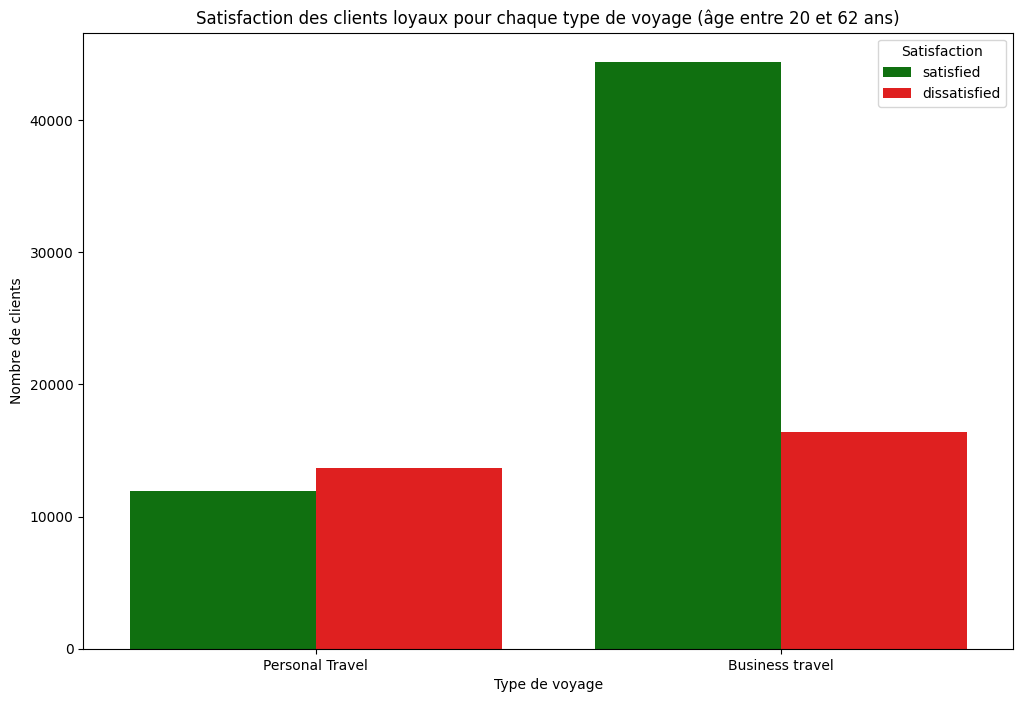

In [14]:
# Grouper par type de voyage et satisfaction
travel_satisfaction_dist = df_loyal.groupBy("Type of Travel", "satisfaction").count().toPandas()

# Renommer les colonnes pour plus de clarté
travel_satisfaction_dist.columns = ['Type of Travel', 'Satisfaction', 'Count']

# Afficher le diagramme en barres groupées de la satisfaction des clients pour chaque type de voyage
colors = ['green', 'red']
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Type of Travel',
    y='Count',
    hue='Satisfaction',
    data=travel_satisfaction_dist,
    palette=colors
)
plt.title("Satisfaction des clients loyaux pour chaque type de voyage (âge entre 20 et 62 ans)")
plt.xlabel("Type de voyage")
plt.ylabel("Nombre de clients")
plt.legend(title='Satisfaction')
plt.show()

### 5.2 Satisfaction des clients **loyaux** voyageant pour **affaire

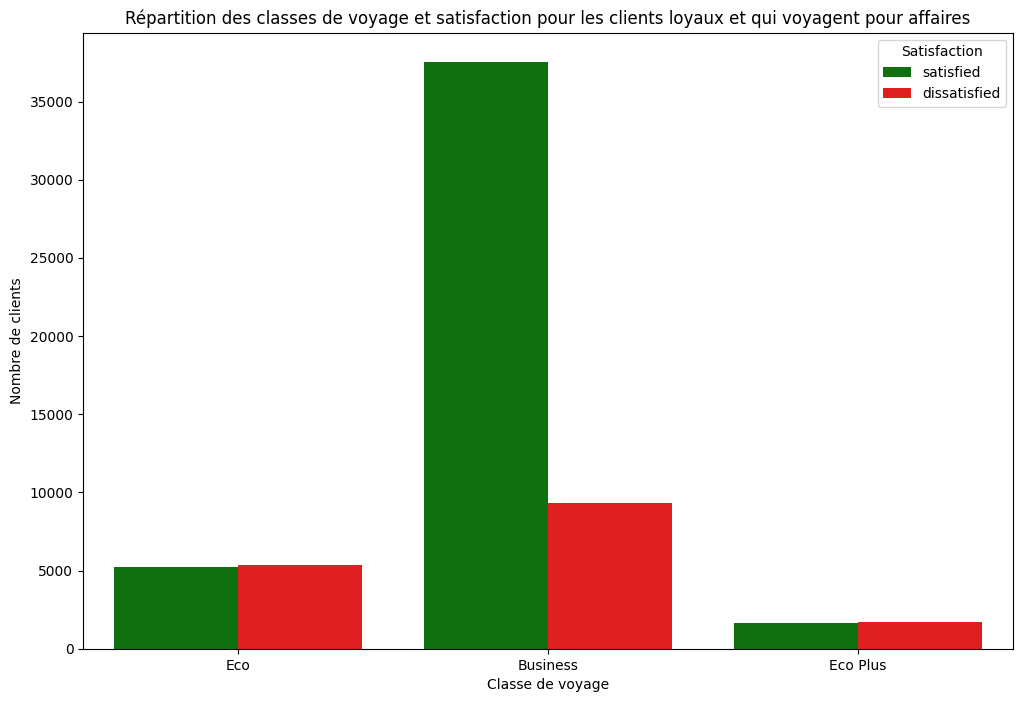

In [15]:
# Filtrer les données pour les clients loyaux et qui voyagent pour affaires
filtered_df = df_loyal.filter(df_loyal["Type of Travel"] == "Business travel")

# Calculer la répartition par classes de voyage
class_satisfaction_distribution = filtered_df.groupBy("Class", "satisfaction").count().toPandas()

# Afficher un diagramme en barres empilées pour visualiser la répartition par classes et satisfaction
colors = ['green', 'red']
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Class',
    y='count',
    hue='satisfaction',
    data=class_satisfaction_distribution,
    palette=colors
)
plt.title("Répartition des classes de voyage et satisfaction pour les clients loyaux et qui voyagent pour affaires")
plt.xlabel("Classe de voyage")
plt.ylabel("Nombre de clients")
plt.legend(title='Satisfaction')
plt.show()

### 5.3 Satisfaction des clients **loyaux** voyageant pour **autre chose**

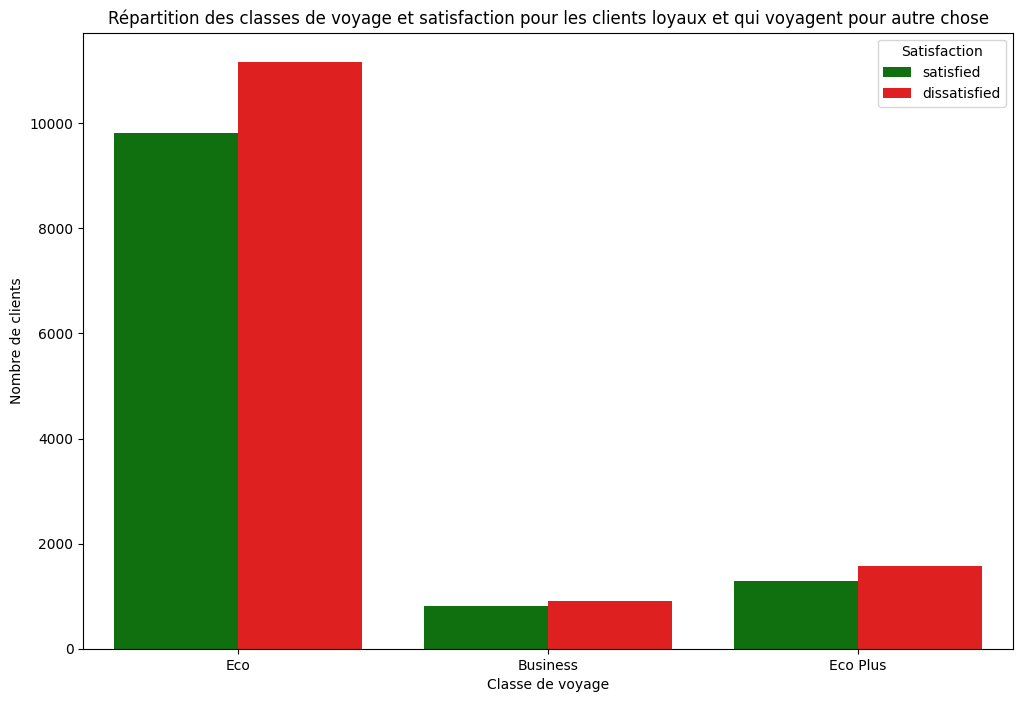

In [16]:
# Filtrer les données pour les clients loyaux et qui voyagent pour affaires
filtered_df = df_loyal.filter(df_loyal["Type of Travel"] == "Personal Travel")

# Calculer la répartition par classes de voyage
class_satisfaction_distribution = filtered_df.groupBy("Class", "satisfaction").count().toPandas()

# Afficher un diagramme en barres empilées pour visualiser la répartition par classes et satisfaction
colors = ['green', 'red']
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Class',
    y='count',
    hue='satisfaction',
    data=class_satisfaction_distribution,
    palette=colors
)
plt.title("Répartition des classes de voyage et satisfaction pour les clients loyaux et qui voyagent pour autre chose")
plt.xlabel("Classe de voyage")
plt.ylabel("Nombre de clients")
plt.legend(title='Satisfaction')
plt.show()

### 5.4 Focus sur la **classe Eco**

In [32]:
df_loyal_eco = df_loyal.filter(
    (df["Customer Type"] == "Loyal Customer") &
    (df["Class"] == "Eco")
)

In [33]:
# Séparer les clients satisfaits et insatisfaits
df_satisfied = df_loyal_eco.filter(df_loyal_eco["satisfaction"] == "satisfied")
df_dissatisfied = df_loyal_eco.filter(df_loyal_eco["satisfaction"] == "dissatisfied")

### **Notes données** aux services par les clients

In [1]:
# Paramètres à analyser
parameters = ["Seat comfort", "Departure/Arrival time convenient", "Food and drink", 
              "Gate location", "Inflight wifi service", "Inflight entertainment", 
              "Online support", "Ease of Online booking", "On-board service", 
              "Leg room service", "Baggage handling", "Checkin service", 
              "Cleanliness", "Online boarding"]

# Calculer la moyenne des notes pour chaque paramètre pour les clients satisfaits
satisfied_means = df_satisfied.select(parameters).groupBy().mean().toPandas().transpose()
satisfied_means.columns = ['Satisfied']
satisfied_means['Parameter'] = satisfied_means.index
satisfied_means['Parameter'] = satisfied_means['Parameter'].str.replace("avg(", "").str.replace(")", "")

# Calculer la moyenne des notes pour chaque paramètre pour les clients insatisfaits
dissatisfied_means = df_dissatisfied.select(parameters).groupBy().mean().toPandas().transpose()
dissatisfied_means.columns = ['Dissatisfied']
dissatisfied_means['Parameter'] = dissatisfied_means.index
dissatisfied_means['Parameter'] = dissatisfied_means['Parameter'].str.replace("avg(", "").str.replace(")", "")

# Combiner les moyennes dans un seul DataFrame
means_df = pd.merge(satisfied_means, dissatisfied_means, on='Parameter')
means_melted = means_df.melt(
    id_vars='Parameter',
    value_vars=['Satisfied', 'Dissatisfied'], 
    var_name='Satisfaction',
    value_name='Average Score'
)


from pyspark.sql import Row
from pyspark.sql.functions import mean

# Calculer la moyenne des notes pour chaque paramètre pour les clients satisfaits
satisfied_means = df_satisfied.select(parameters).agg(*[mean(col(p)).alias(p) for p in parameters])
# Calculer la moyenne des notes pour chaque paramètre pour les clients insatisfaits
dissatisfied_means = df_dissatisfied.select(parameters).agg(*[mean(col(p)).alias(p) for p in parameters])
# Convertir les DataFrames en RDDs et les joindre
satisfied_means_rdd = satisfied_means.rdd.flatMap(
    lambda row: [(parameter, row[parameter]) for parameter in parameters])
dissatisfied_means_rdd = dissatisfied_means.rdd.flatMap(
    lambda row: [(parameter, row[parameter]) for parameter in parameters])

satisfied_means_df = spark.createDataFrame(satisfied_means_rdd.map(lambda x: Row(Parameter=x[0], Satisfied=x[1])))
dissatisfied_means_df = spark.createDataFrame(
    dissatisfied_means_rdd.map(lambda x: Row(Parameter=x[0], Dissatisfied=x[1])))
# Joindre les DataFrames sur le paramètre
means_df = satisfied_means_df.join(dissatisfied_means_df, on="Parameter", how="outer")
# Réorganiser les données avec melt (ou l'équivalent en PySpark)
from pyspark.sql.functions import expr
# Ajouter une colonne 'Satisfaction' avec des valeurs pour le melting
means_df = means_df.withColumn(
    "Satisfaction",
    expr("CASE WHEN Satisfied IS NOT NULL THEN 'Satisfied' ELSE 'Dissatisfied' END"))
# Convertir les colonnes de satisfaction en une seule colonne
means_df = means_df.selectExpr("Parameter", "Satisfaction", "coalesce(Satisfied, Dissatisfied) as Average_Score")
means_df

# # Afficher le graphique
# plt.figure(figsize=(14, 8))
# ax = sns.barplot(
#     x='Parameter',
#     y='Average Score',
#     hue='Satisfaction',
#     data=means_melted,
#     palette=['green', 'red']
# )
# plt.title("Moyenne des notes par paramètre pour les clients loyaux satisfaits et insatisfaits")
# plt.xlabel("Paramètre")
# plt.ylabel("Note moyenne")
# plt.xticks(rotation=75)
# plt.legend(title='Satisfaction')

# # Ajouter les moyennes au-dessus des barres
# for p in ax.patches:
#     if p.get_height() > 0:
#         ax.annotate(
#             format(p.get_height(), '.2f'), 
#             (p.get_x() + p.get_width() / 2., p.get_height()), 
#             ha='center', va='center', 
#             xytext=(0, 9), 
#             textcoords='offset points'
#         )

# plt.show()

NameError: name 'df_satisfied' is not defined

### 5.5 Distribution des **distances de vols**

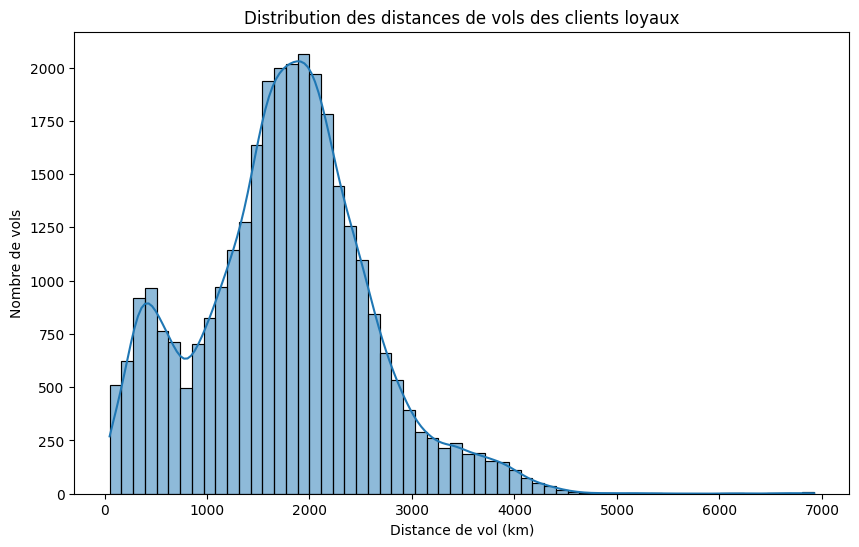

In [21]:
# Sélectionner la colonne des distances de vols et convertir en DataFrame Pandas
distance_dist = df_loyal_eco.select("Flight Distance").toPandas()

# Afficher l'histogramme de la distribution des distances de vols
plt.figure(figsize=(10, 6))
sns.histplot(distance_dist['Flight Distance'], bins=60, kde=True)
plt.title("Distribution des distances de vols des clients loyaux")
plt.xlabel("Distance de vol (km)")
plt.ylabel("Nombre de vols")
plt.show()

/tmp/ipykernel_95442/139346690.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  satisfaction_counts = df_pd.groupby(['Distance Bin', 'satisfaction']).size().unstack(fill_value=0)
posx and posy should be finite values
posx and posy should be finite values


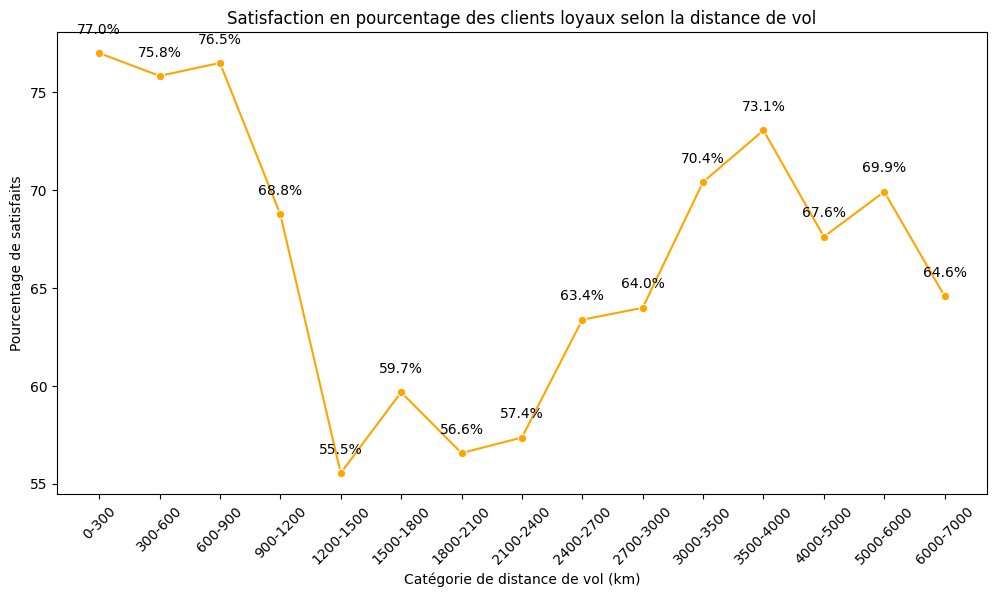

In [22]:
# On garde la distance de vol et la satisfaction
df_pd = df_loyal.select("Flight Distance", "satisfaction").toPandas()
# df_pd = loyal_eco_df.select("Flight Distance", "satisfaction").toPandas()

# Supprimer les lignes avec des valeurs manquantes
df_pd.dropna(subset=["Flight Distance", "satisfaction"], inplace=True)

# Créer des bins pour l'histogramme
bins = [0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3500, 4000, 5000, 6000, 7000, 8000]
labels = ['0-300', '300-600', '600-900', '900-1200', '1200-1500', '1500-1800', 
          '1800-2100', '2100-2400', '2400-2700', '2700-3000', '3000-3500',
          '3500-4000', '4000-5000', '5000-6000', '6000-7000', '7000-8000']

# Ajouter une colonne pour les bins de distance de vol
df_pd['Distance Bin'] = pd.cut(df_pd['Flight Distance'], bins=bins, labels=labels)

# Calculer le nombre de clients satisfaits et total dans chaque bin
satisfaction_counts = df_pd.groupby(['Distance Bin', 'satisfaction']).size().unstack(fill_value=0)
total_counts = satisfaction_counts.sum(axis=1)

# Calculer le pourcentage de clients satisfaits dans chaque bin
satisfaction_percentage = (satisfaction_counts['satisfied'] / total_counts) * 100

# Convertir en DataFrame Pandas pour la visualisation
satisfaction_percentage = satisfaction_percentage.reset_index()

# Afficher un graphique en courbe pour visualiser le pourcentage de satisfaits selon la distance de vol
plt.figure(figsize=(12, 6))
sns.lineplot(x='Distance Bin', y=0, data=satisfaction_percentage, marker='o', color='orange')
plt.title("Satisfaction en pourcentage des clients loyaux selon la distance de vol")
plt.xlabel("Catégorie de distance de vol (km)")
plt.ylabel("Pourcentage de satisfaits")

# Ajouter les pourcentages au-dessus de chaque point
for i in range(len(satisfaction_percentage)):
    plt.text(i, satisfaction_percentage[0][i] + 1, f'{satisfaction_percentage[0][i]:.1f}%', ha='center', color='black')

plt.xticks(rotation=45)
plt.show()

### 5.6 **Satisfaction** par paramètre selon la **distance de vol**

/tmp/ipykernel_95442/174573284.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_satisfied = df_satisfied_pd.groupby('Distance Bin')[params].mean().reset_index()
/tmp/ipykernel_95442/174573284.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_dissatisfied = df_dissatisfied_pd.groupby('Distance Bin')[params].mean().reset_index()


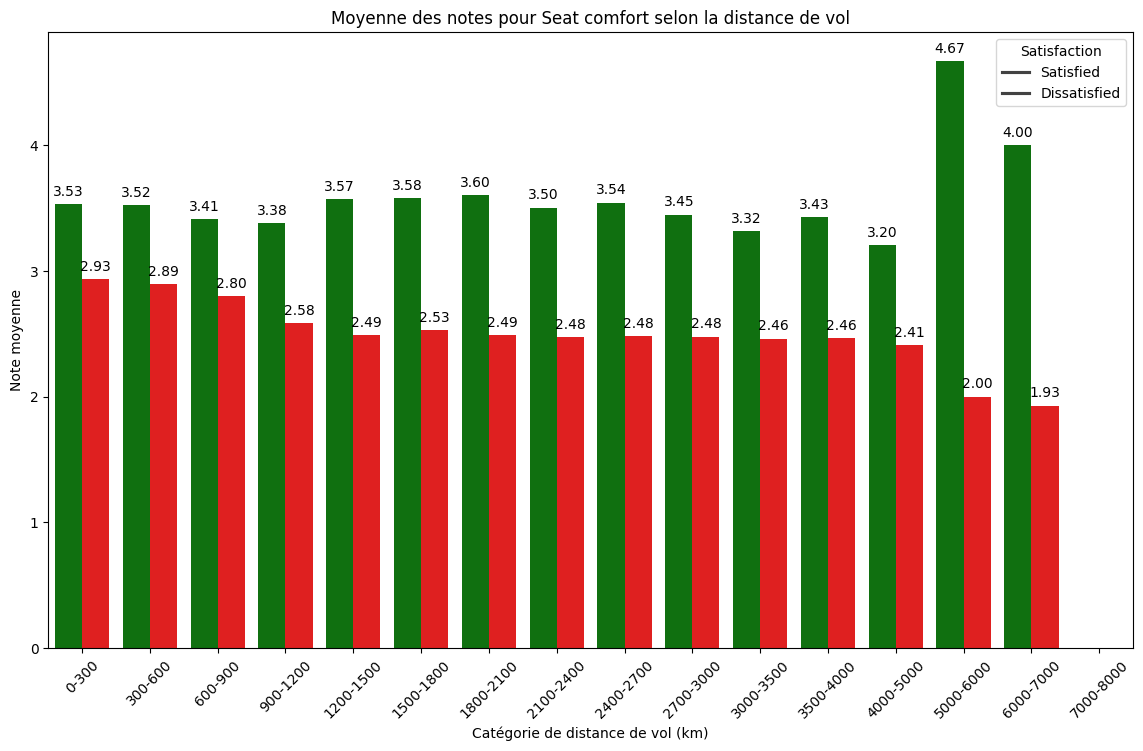

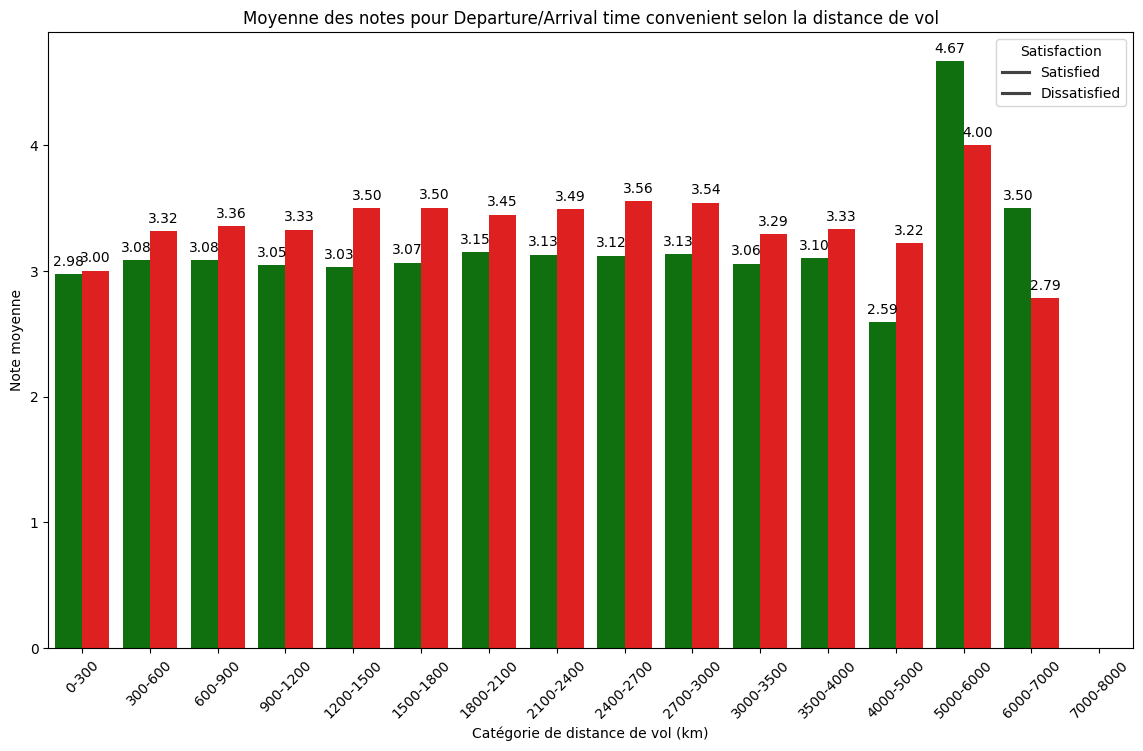

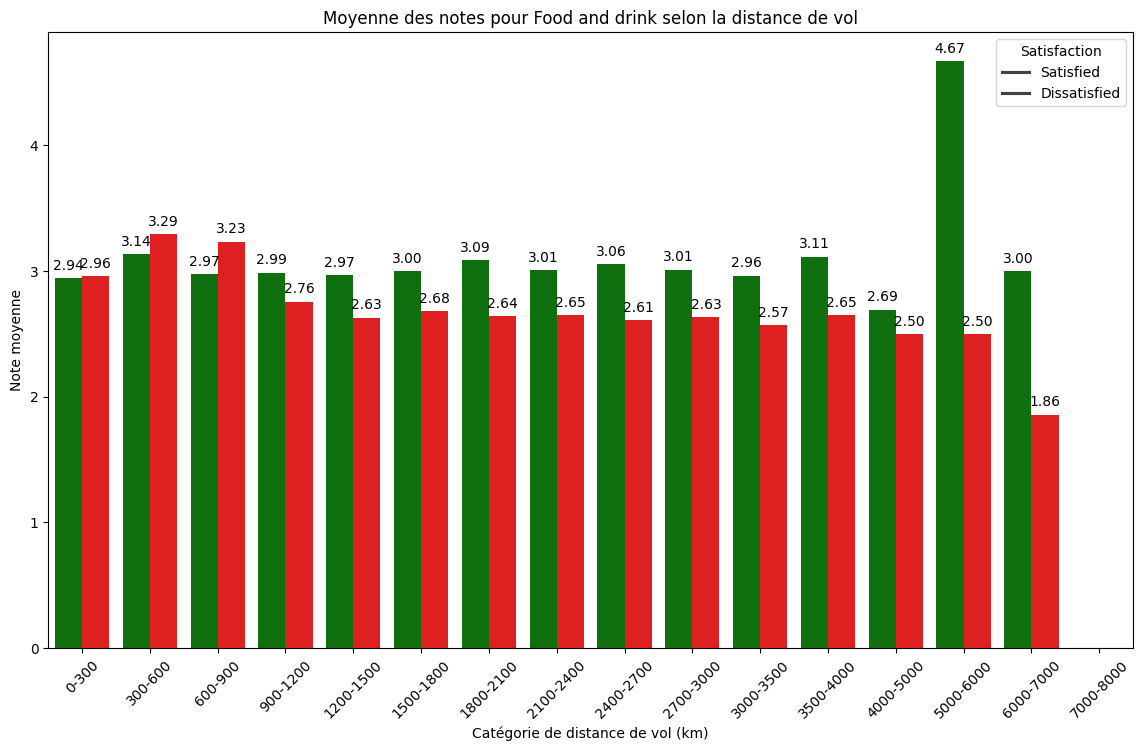

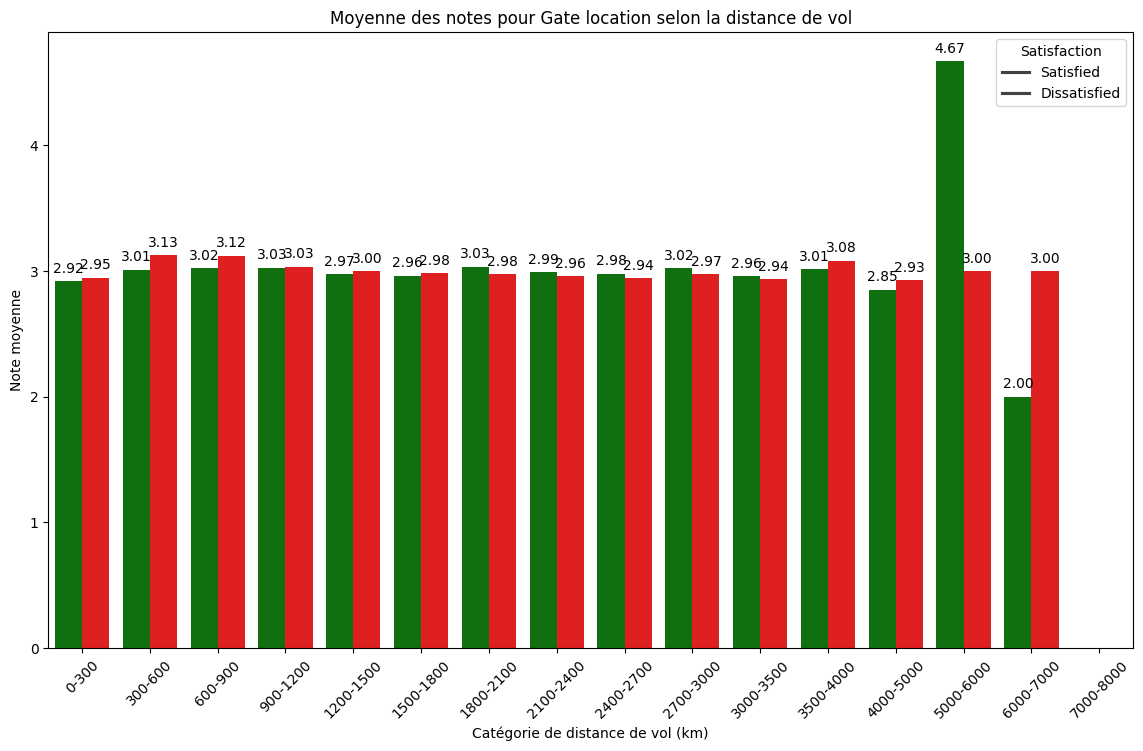

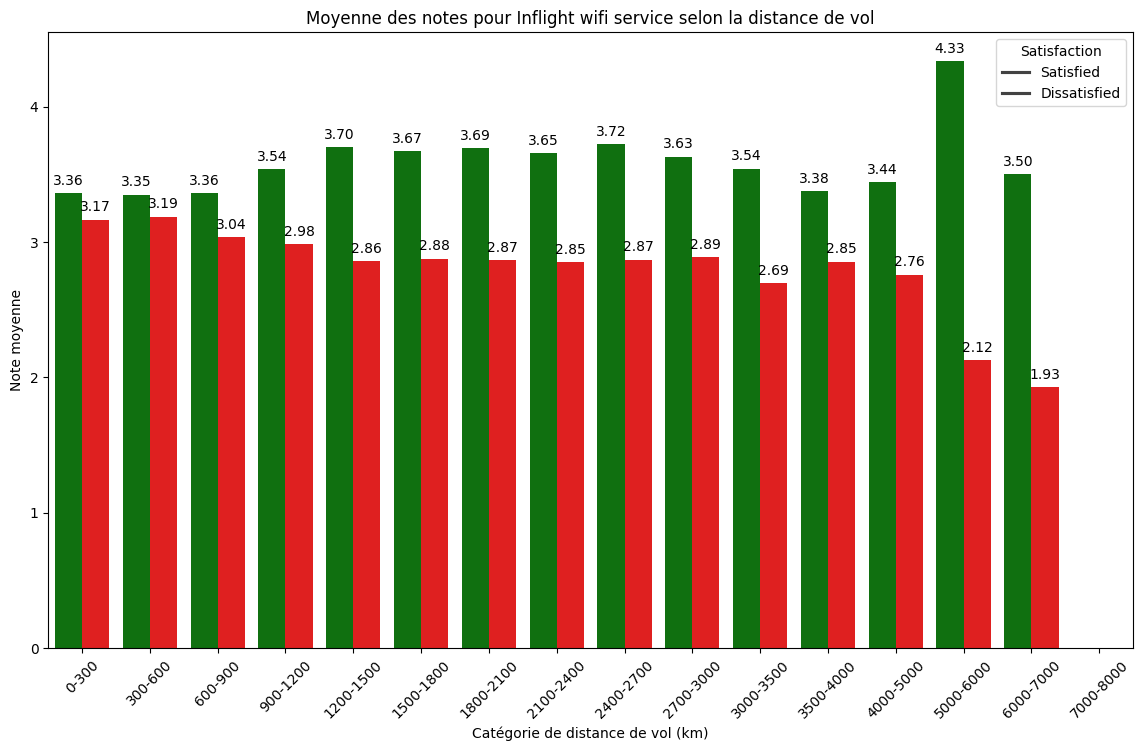

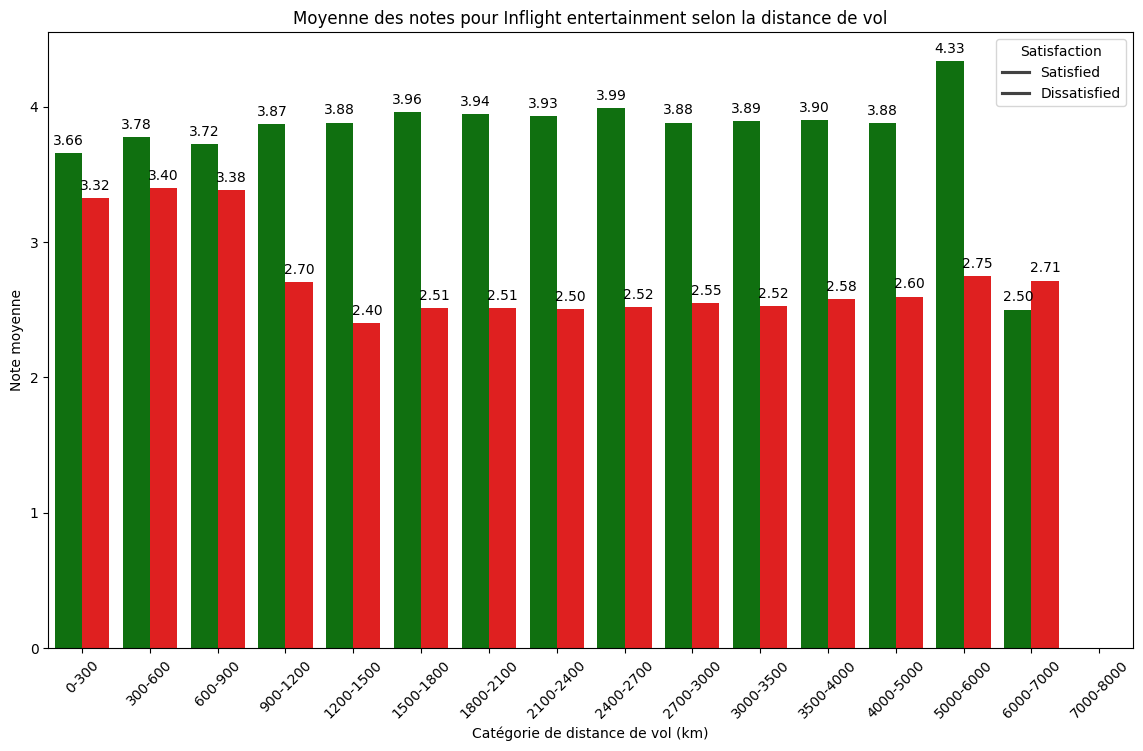

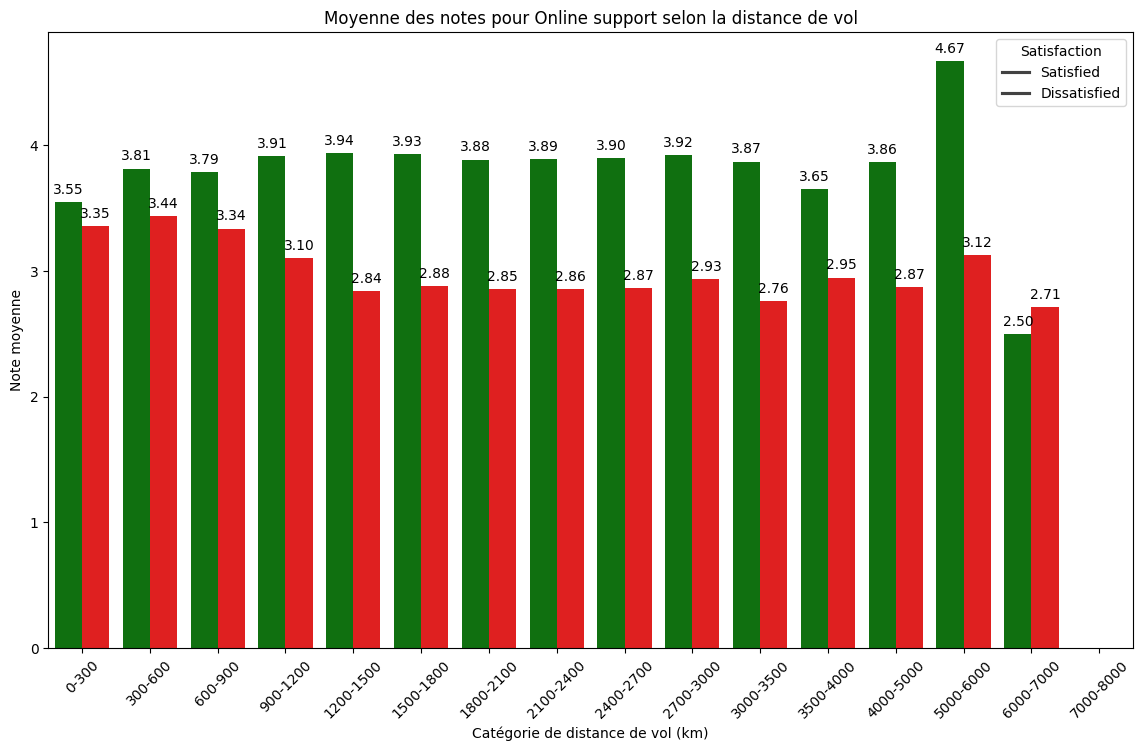

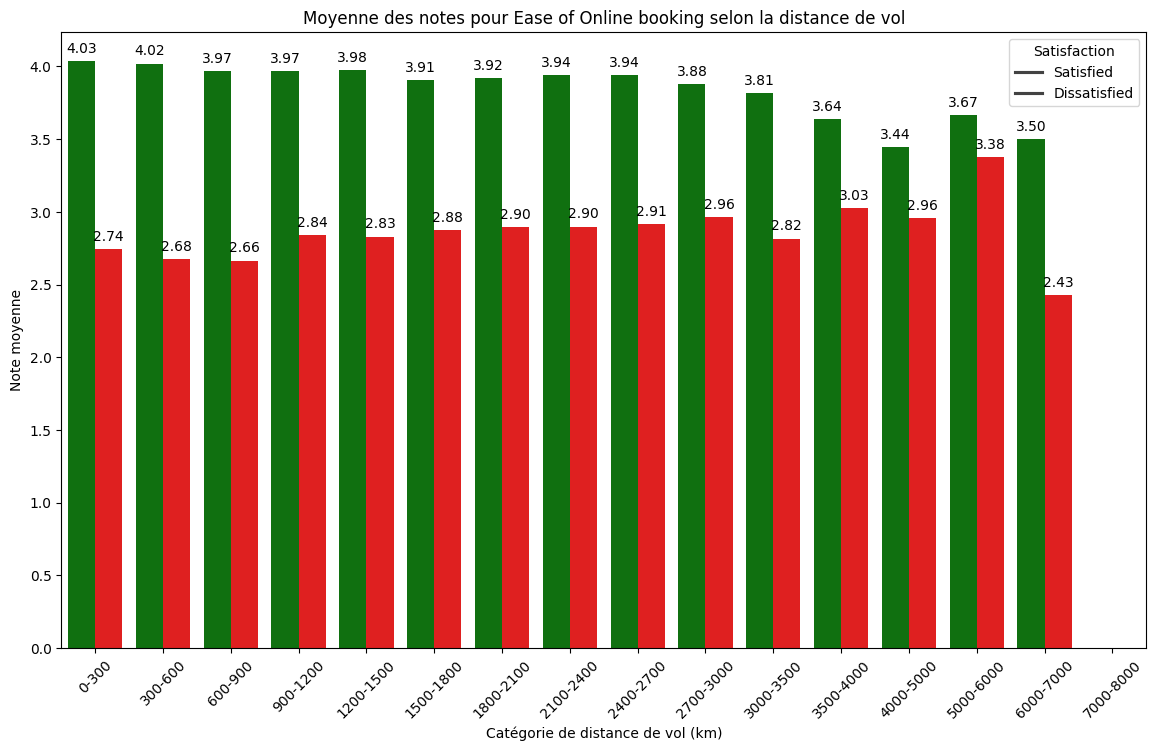

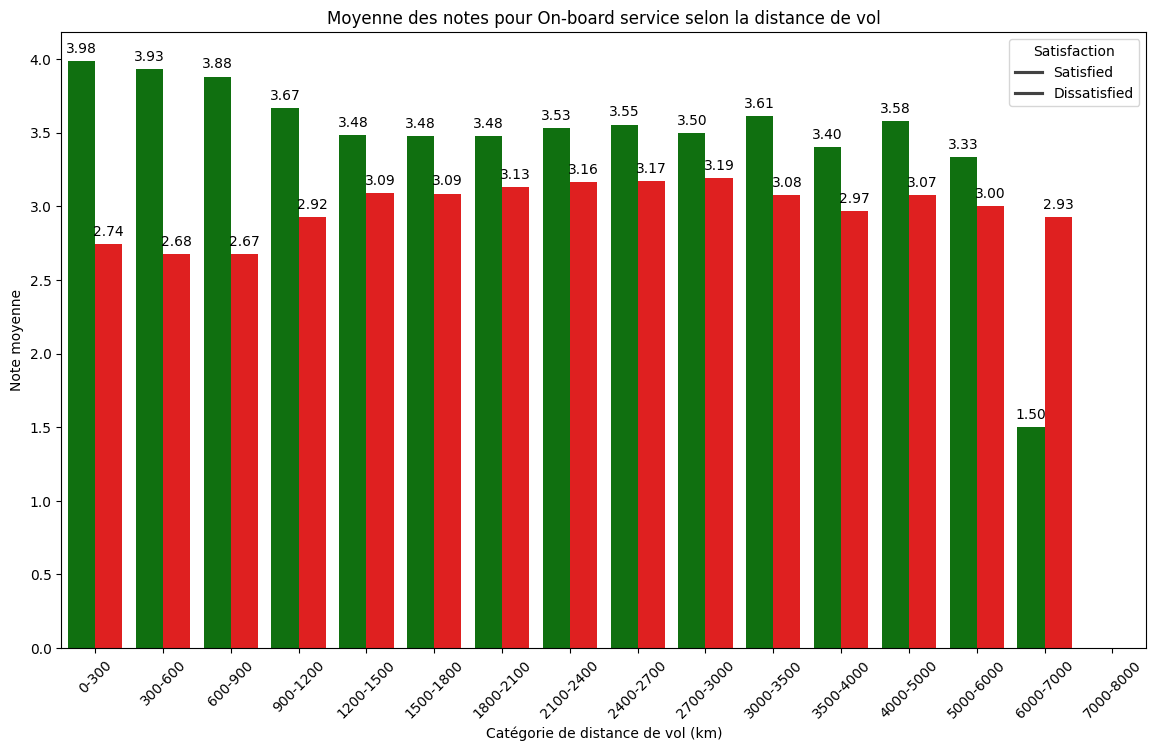

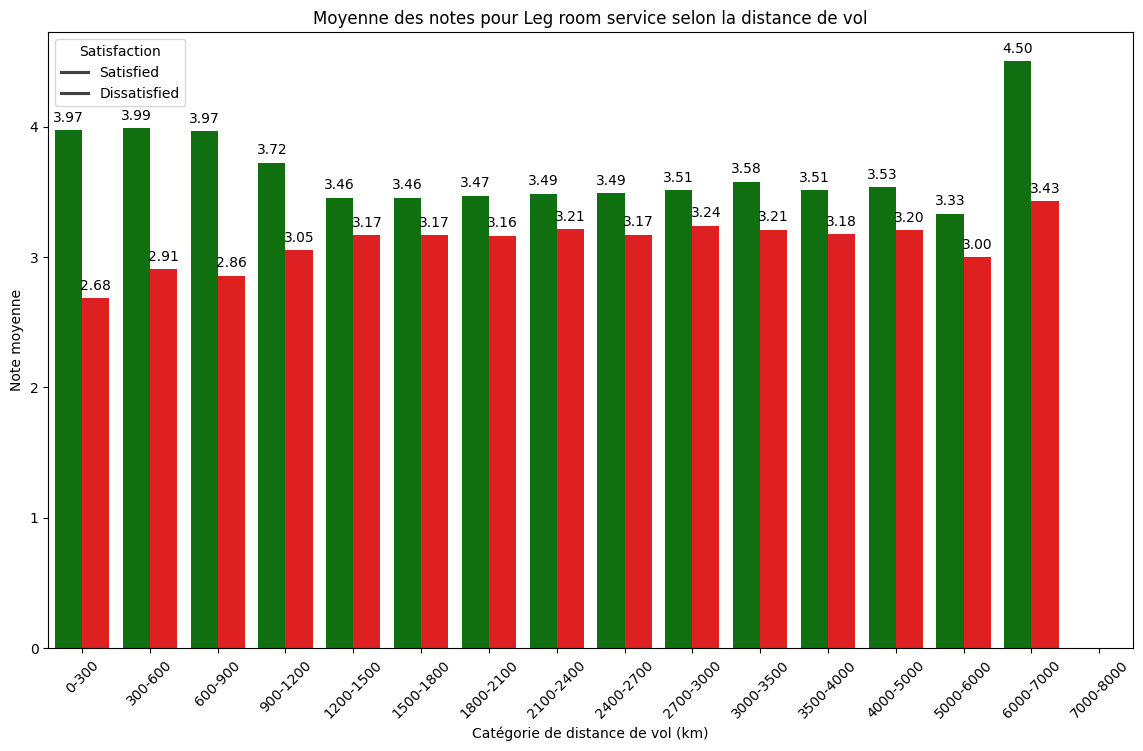

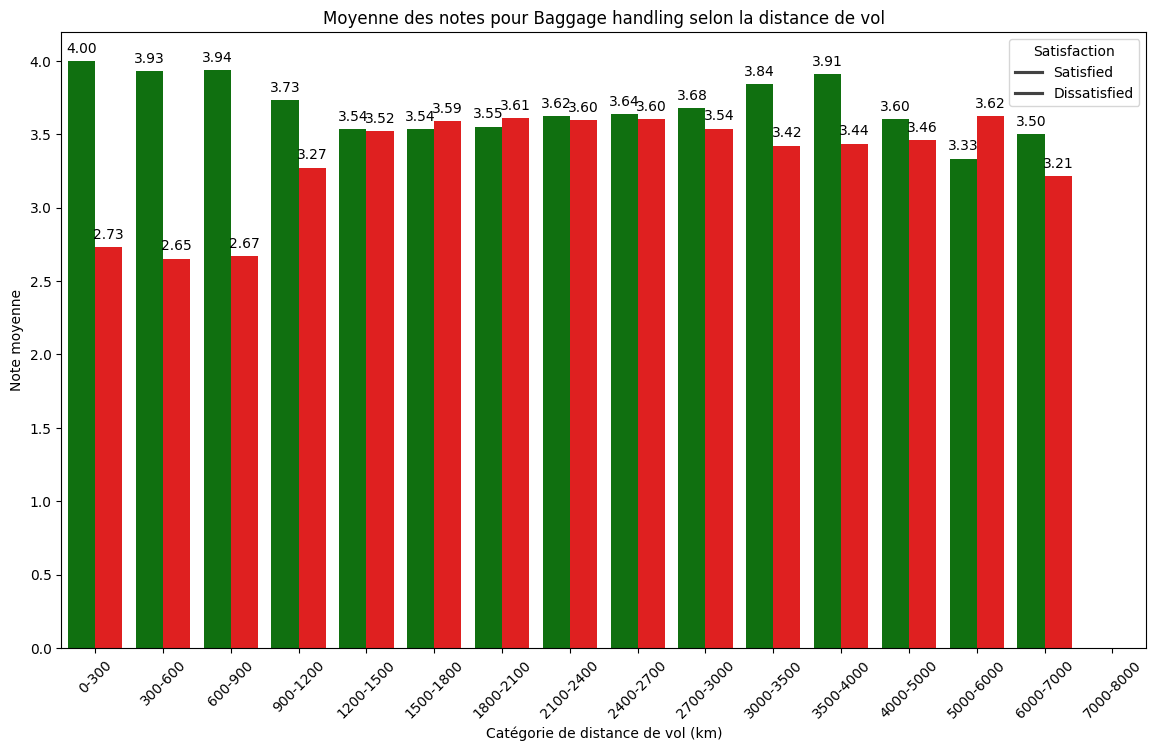

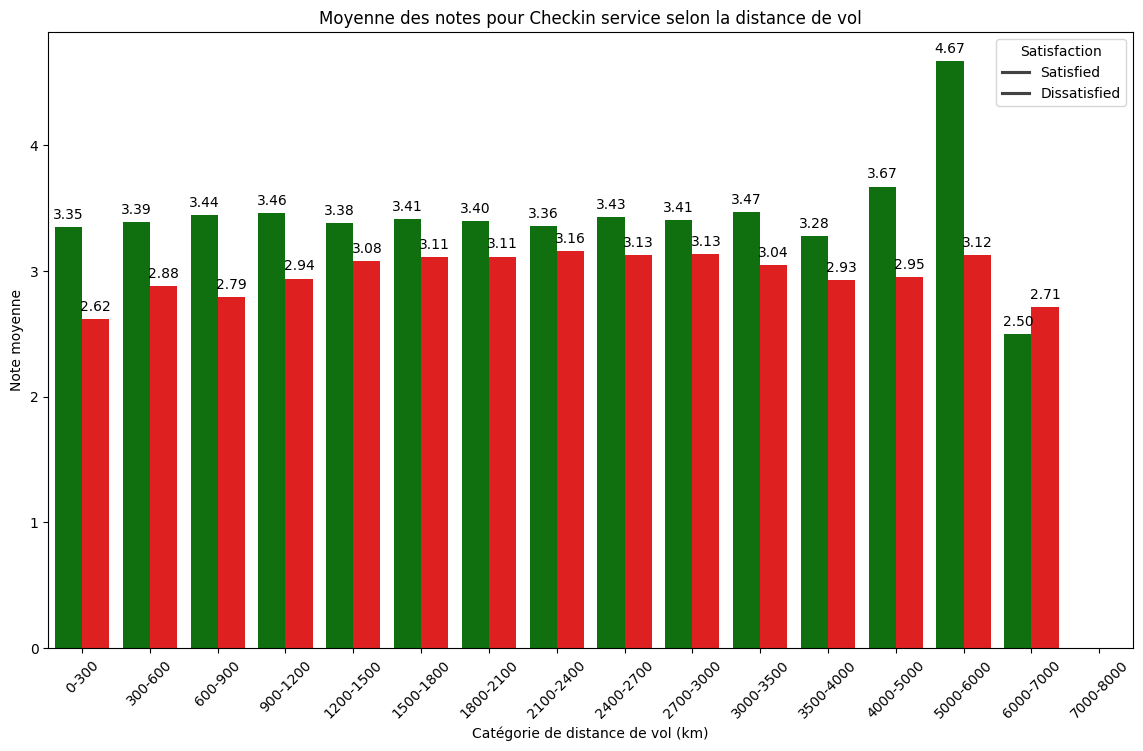

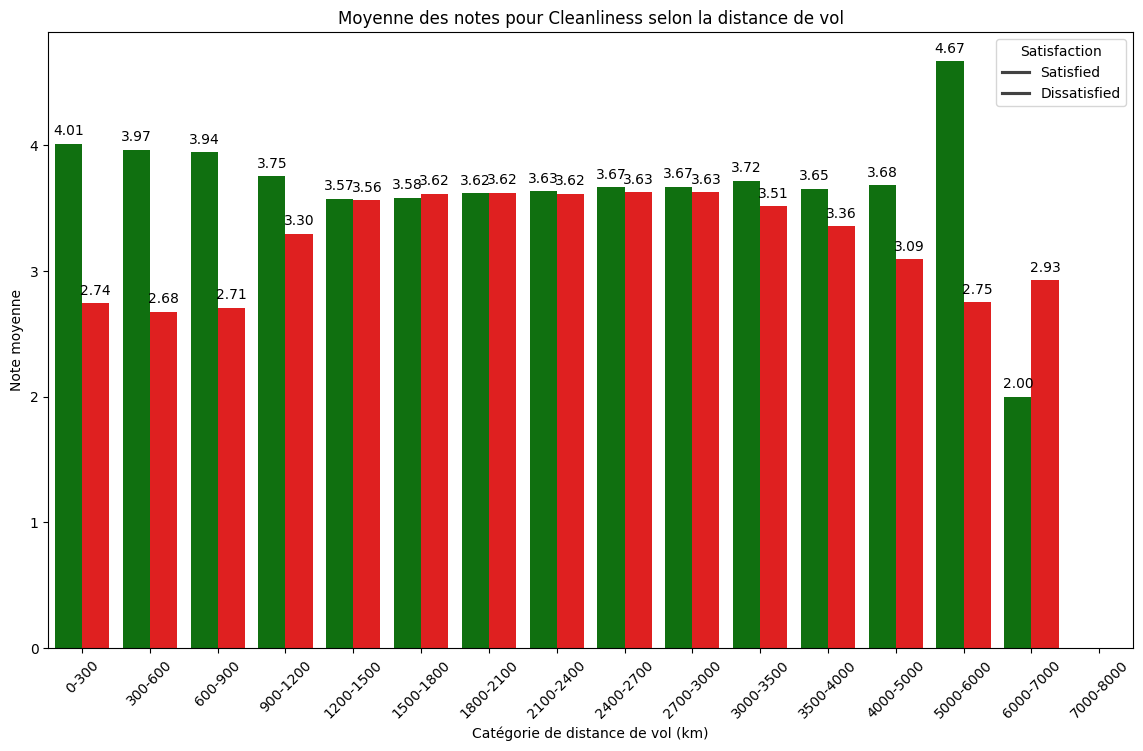

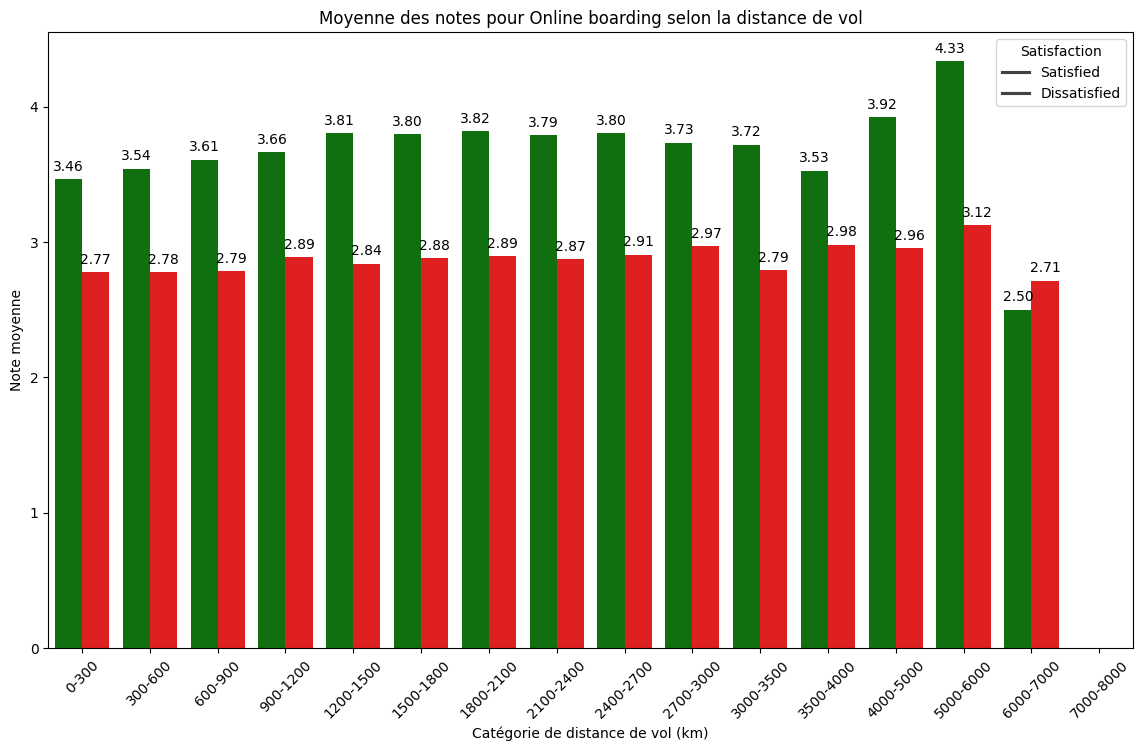

In [23]:
# Convertir en DataFrame Pandas pour faciliter la manipulation
df_loyal_pd = df_loyal_eco.select(
    "Flight Distance", "satisfaction", "Seat comfort", "Departure/Arrival time convenient", 
    "Food and drink", "Gate location", "Inflight wifi service", "Inflight entertainment", 
    "Online support", "Ease of Online booking", "On-board service", "Leg room service", 
    "Baggage handling", "Checkin service", "Cleanliness", "Online boarding").toPandas()

# Supprimer les lignes avec des valeurs manquantes
df_loyal_pd.dropna(subset=["Flight Distance", "satisfaction"], inplace=True)

# Créer des bins pour l'histogramme
bins = [
    0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400,
    2700, 3000, 3500, 4000, 5000, 6000, 7000, 8000
]
labels = [
    '0-300', '300-600', '600-900', '900-1200', '1200-1500', '1500-1800', 
    '1800-2100', '2100-2400', '2400-2700', '2700-3000', '3000-3500',
    '3500-4000', '4000-5000', '5000-6000', '6000-7000', '7000-8000'
]
df_loyal_pd['Distance Bin'] = pd.cut(
    df_loyal_pd['Flight Distance'],
    bins=bins,
    labels=labels,
    right=False
)

# Séparer les clients satisfaits et insatisfaits
df_satisfied_pd = df_loyal_pd[df_loyal_pd['satisfaction'] == 'satisfied']
df_dissatisfied_pd = df_loyal_pd[df_loyal_pd['satisfaction'] == 'dissatisfied']

# Calculer les notes moyennes pour chaque paramètre et chaque bin
params = [
    "Seat comfort", "Departure/Arrival time convenient", "Food and drink", "Gate location", 
    "Inflight wifi service", "Inflight entertainment", "Online support", "Ease of Online booking", 
    "On-board service", "Leg room service", "Baggage handling", "Checkin service", "Cleanliness", 
    "Online boarding"
]

avg_satisfied = df_satisfied_pd.groupby('Distance Bin')[params].mean().reset_index()
avg_dissatisfied = df_dissatisfied_pd.groupby('Distance Bin')[params].mean().reset_index()
# Fusionner les deux DataFrames pour comparaison
avg_scores = pd.merge(
    avg_satisfied,
    avg_dissatisfied,
    on='Distance Bin',
    suffixes=('_satisfied', '_dissatisfied')
)

# Afficher les résultats
for param in params:
    plt.figure(figsize=(14, 8))
    avg_scores_melted = avg_scores.melt(
        id_vars='Distance Bin', 
        value_vars=[f'{param}_satisfied', f'{param}_dissatisfied'],
        var_name='Satisfaction',
        value_name='Average Score'
    )
    ax = sns.barplot(
        x='Distance Bin',
        y='Average Score',
        hue='Satisfaction',
        data=avg_scores_melted,
        palette=['green', 'red']
    )
    plt.title(f"Moyenne des notes pour {param} selon la distance de vol")
    plt.xlabel("Catégorie de distance de vol (km)")
    plt.ylabel("Note moyenne")
    plt.legend(title='Satisfaction', labels=['Satisfied', 'Dissatisfied'])
    plt.xticks(rotation=45)

    # Ajouter les moyennes au-dessus des barres
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(
                format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points'
            )

    plt.show()

## **6. Analyse des clients NON-LOYAUX**

In [65]:
df_disloyal = df_age_filtered.filter(age_filtered_df["Customer Type"] == "disloyal Customer")

### 6.1 Satisfaction par **type de voyage**

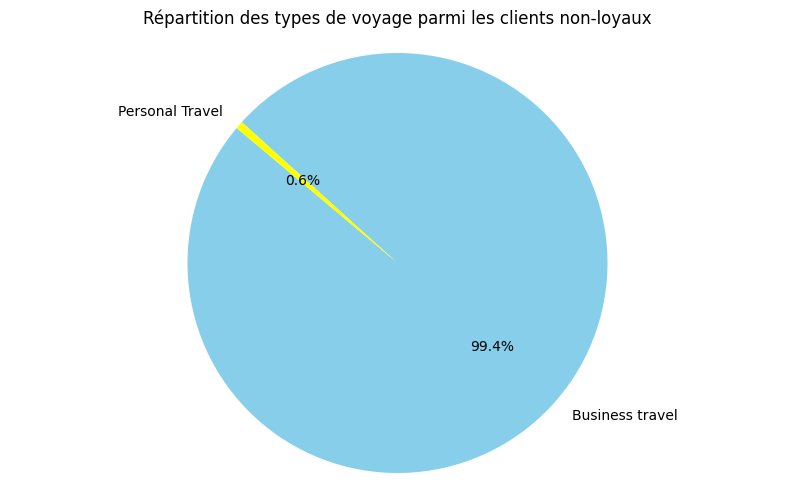

In [145]:
# Grouper par type de voyage
travel_type_dist = df_disloyal.groupBy("Type of Travel").count().toPandas()
travel_type_dist['percentage'] = (travel_type_dist['count'] / total_count) * 100

# Affichage
colors = ['skyblue', 'yellow']
plt.figure(figsize=(10, 6))
plt.pie(
    travel_type_dist['percentage'],
    labels=travel_type_dist['Type of Travel'],
df_encoded    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)
plt.title("Répartition des types de voyage parmi les clients non-loyaux")
plt.axis('equal')  # Assurer que le graphique est en cercle
plt.show()

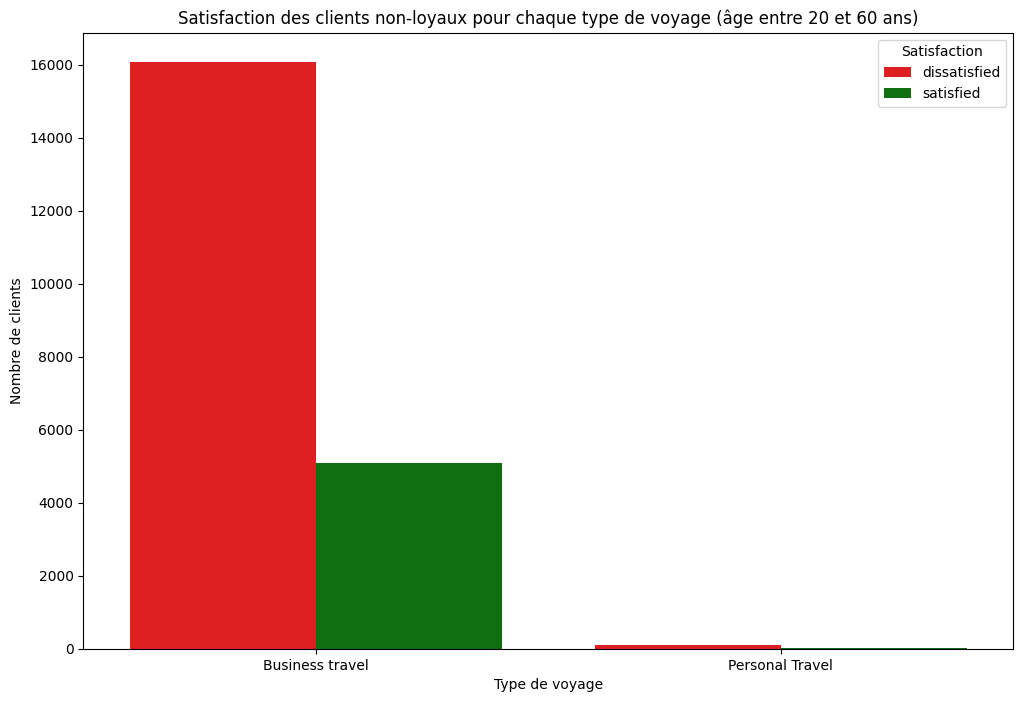

In [158]:
# Grouper par type de voyage et satisfaction
travel_satisfaction_dist = df_disloyal.groupBy("Type of Travel", "satisfaction").count().toPandas()

# Renommer les colonnes pour plus de clarté
travel_satisfaction_dist.columns = ['Type of Travel', 'Satisfaction', 'Count']

# Afficher le diagramme en barres groupées de la satisfaction des clients pour chaque type de voyage
colors = ['red', 'green']
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Type of Travel',
    y='Count',
    hue='Satisfaction',
    data=travel_satisfaction_dist,
    palette=colors
)
plt.title("Satisfaction des clients non-loyaux pour chaque type de voyage (âge entre 20 et 60 ans)")
plt.xlabel("Type de voyage")
plt.ylabel("Nombre de clients")
plt.legend(title='Satisfaction')
plt.show()

### 6.2 Satisfaction des clients **non-loyaux** voyageant pour **affaire**

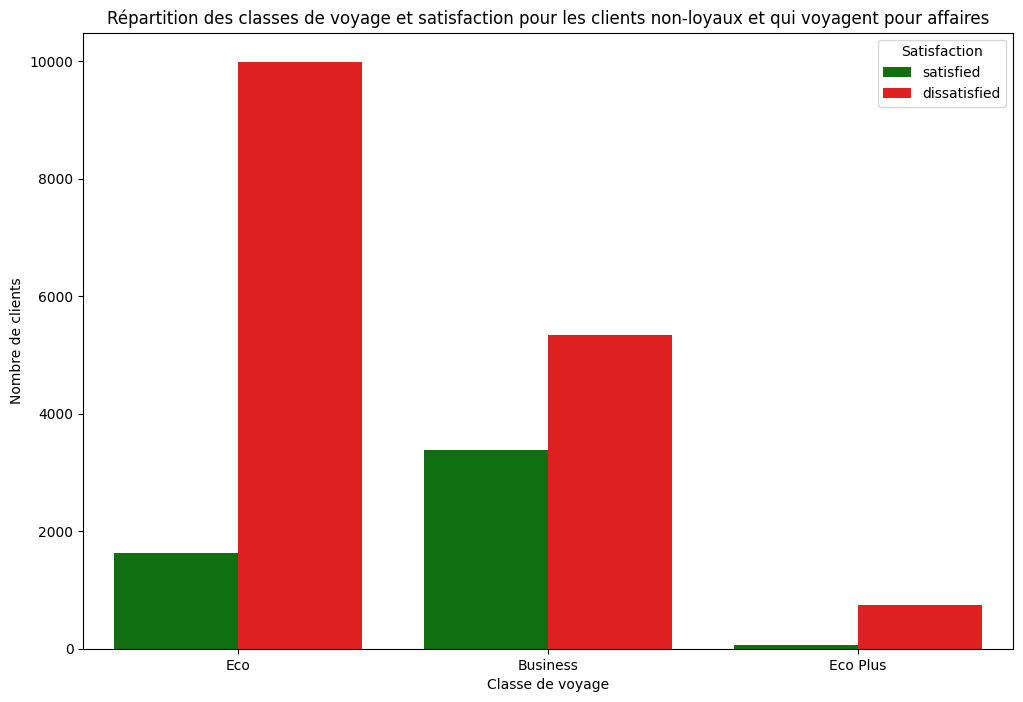

In [165]:
# Filtrer les données pour les clients loyaux et qui voyagent pour affaires
filtered_df = df_disloyal.filter(df["Type of Travel"] == "Business travel")

# Calculer la répartition par classes de voyage
class_satisfaction_distribution = filtered_df.groupBy("Class", "satisfaction").count().toPandas()

# Afficher un diagramme en barres empilées pour visualiser la répartition par classes et satisfaction
colors = ['green', 'red']
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Class',
    y='count',
    hue='satisfaction',
    data=class_satisfaction_distribution,
    palette=colors
)
plt.title("Répartition des classes de voyage et satisfaction pour les clients non-loyaux et qui voyagent pour affaires")
plt.xlabel("Classe de voyage")
plt.ylabel("Nombre de clients")
plt.legend(title='Satisfaction')
plt.show()

### 6.3 Focus sur la **classe Eco**

In [187]:
df_disloyal_eco = df_disloyal.filter(
    (df["Type of Travel"] == "Business travel") &
    (df["Class"] == "Eco")
)

In [188]:
# Séparer les clients satisfaits et insatisfaits
satisfied_df = df_disloyal_eco.filter(filtered_df["satisfaction"] == "satisfied")
dissatisfied_df = df_disloyal_eco.filter(filtered_df["satisfaction"] == "dissatisfied")

### **Notes données** aux services par les clients **Eco**

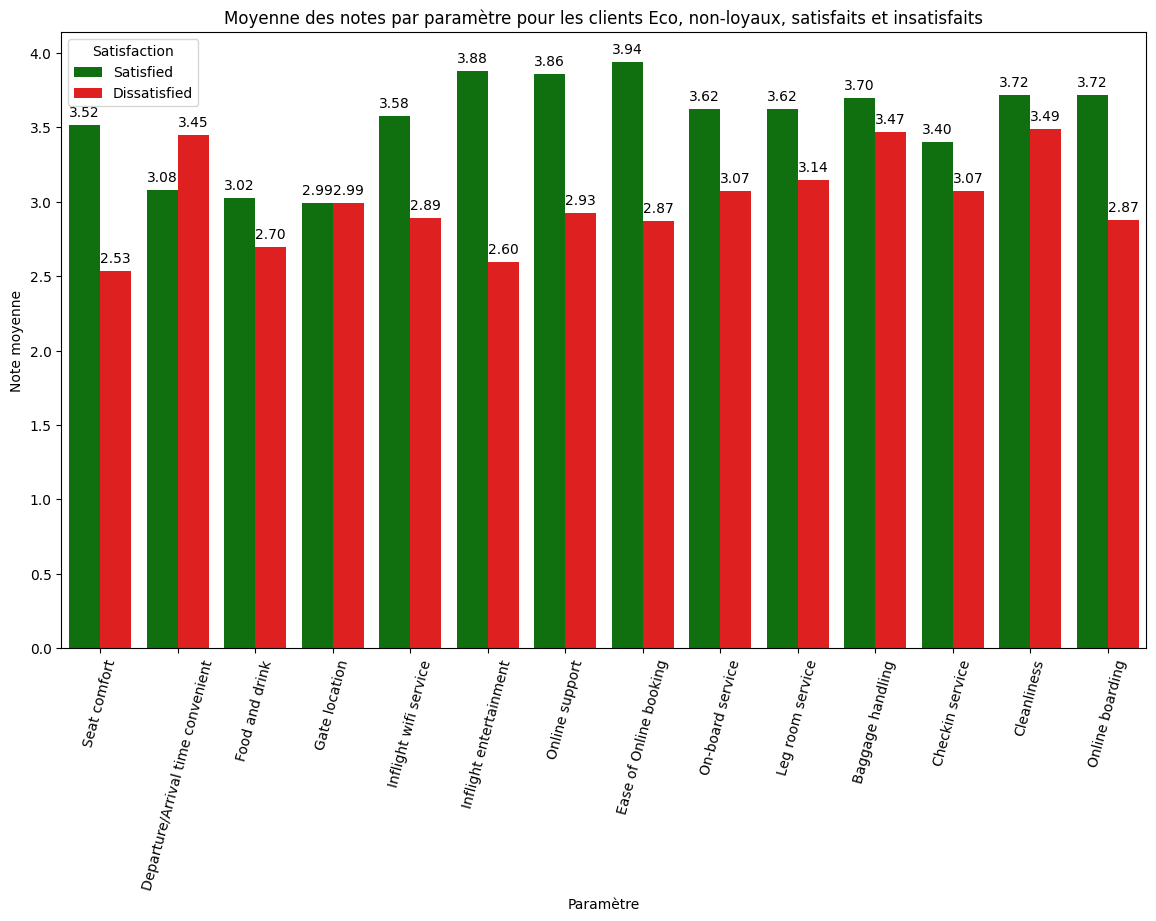

In [189]:
# Paramètres à analyser
parameters = [
    "Seat comfort", "Departure/Arrival time convenient", "Food and drink", 
    "Gate location", "Inflight wifi service", "Inflight entertainment", 
    "Online support", "Ease of Online booking", "On-board service", 
    "Leg room service", "Baggage handling", "Checkin service", 
    "Cleanliness", "Online boarding"
]

# Calculer la moyenne des notes pour chaque paramètre pour les clients satisfaits
satisfied_means = df_satisfied.select(parameters).groupBy().mean().toPandas().transpose()
satisfied_means.columns = ['Satisfied']
satisfied_means['Parameter'] = satisfied_means.index
satisfied_means['Parameter'] = satisfied_means['Parameter'].str.replace("avg(", "").str.replace(")", "")

# Calculer la moyenne des notes pour chaque paramètre pour les clients insatisfaits
dissatisfied_means = df_dissatisfied.select(parameters).groupBy().mean().toPandas().transpose()
dissatisfied_means.columns = ['Dissatisfied']
dissatisfied_means['Parameter'] = dissatisfied_means.index
dissatisfied_means['Parameter'] = dissatisfied_means['Parameter'].str.replace("avg(", "").str.replace(")", "")

# Combiner les moyennes dans un seul DataFrame
means_df = pd.merge(satisfied_means, dissatisfied_means, on='Parameter')
means_melted = means_df.melt(
    id_vars='Parameter',
    value_vars=['Satisfied', 'Dissatisfied'], 
    var_name='Satisfaction',
    value_name='Average Score'
)

# Afficher le graphique
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='Parameter',
    y='Average Score',
    hue='Satisfaction',
    data=means_melted,
    palette=['green', 'red']
)
plt.title("Moyenne des notes par paramètre pour les clients Eco, non-loyaux, satisfaits et insatisfaits")
plt.xlabel("Paramètre")
plt.ylabel("Note moyenne")
plt.xticks(rotation=75)
plt.legend(title='Satisfaction')

# Ajouter les moyennes au-dessus des barres
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            format(p.get_height(), '.2f'), 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 9), 
            textcoords='offset points'
        )

plt.show()

### 6.4 Focus sur la **classe Business**

In [203]:
df_disloyal_busi = df_disloyal.filter(
    (df["Type of Travel"] == "Business travel") &
    (df["Class"] == "Business")
)

In [191]:
# Séparer les clients satisfaits et insatisfaits
satisfied_df = df_disloyal_busi.filter(filtered_df["satisfaction"] == "satisfied")
dissatisfied_df = df_disloyal_busi.filter(filtered_df["satisfaction"] == "dissatisfied")

### **Notes données** aux services par les clients **Business**

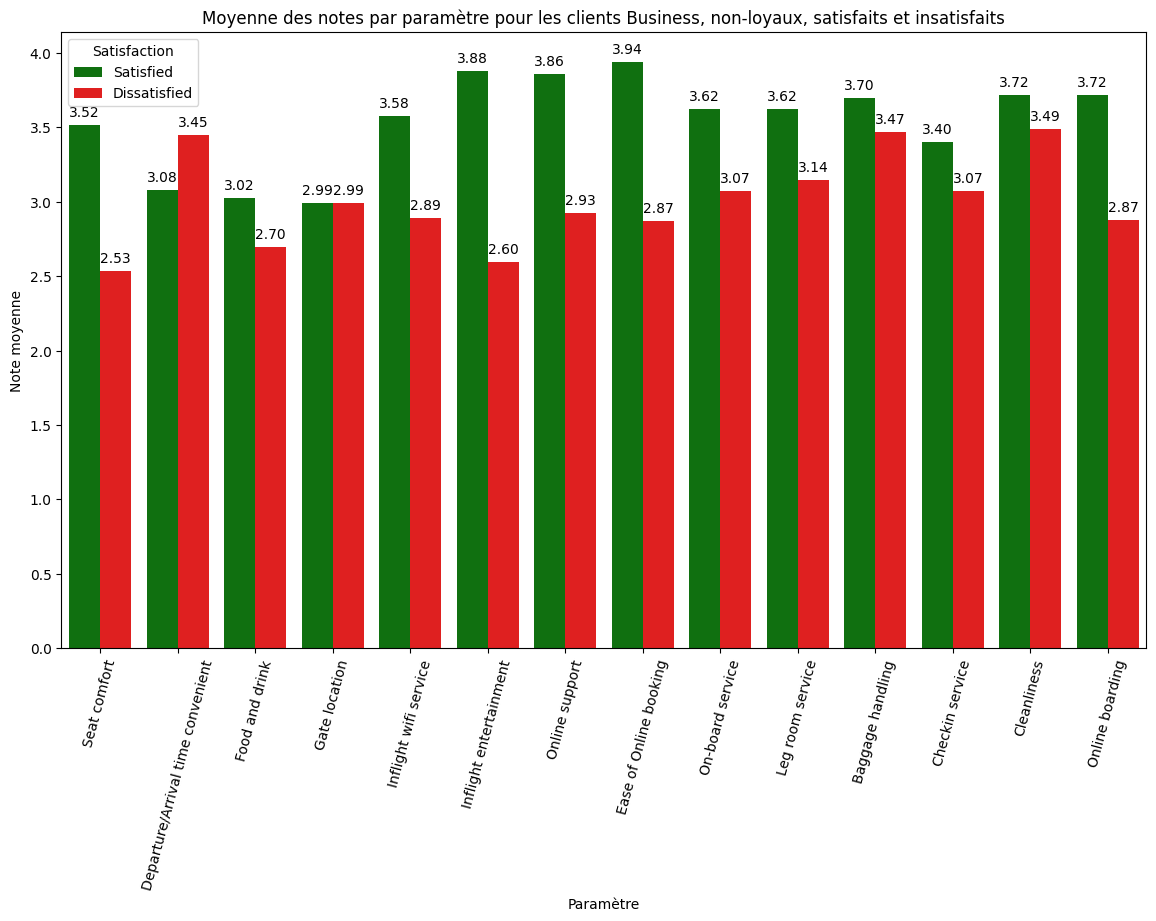

In [192]:
# Paramètres à analyser
parameters = [
    "Seat comfort", "Departure/Arrival time convenient", "Food and drink", 
    "Gate location", "Inflight wifi service", "Inflight entertainment", 
    "Online support", "Ease of Online booking", "On-board service", 
    "Leg room service", "Baggage handling", "Checkin service", 
    "Cleanliness", "Online boarding"
]

# Calculer la moyenne des notes pour chaque paramètre pour les clients satisfaits
satisfied_means = df_satisfied.select(parameters).groupBy().mean().toPandas().transpose()
satisfied_means.columns = ['Satisfied']
satisfied_means['Parameter'] = satisfied_means.index
satisfied_means['Parameter'] = satisfied_means['Parameter'].str.replace("avg(", "").str.replace(")", "")

# Calculer la moyenne des notes pour chaque paramètre pour les clients insatisfaits
dissatisfied_means = df_dissatisfied.select(parameters).groupBy().mean().toPandas().transpose()
dissatisfied_means.columns = ['Dissatisfied']
dissatisfied_means['Parameter'] = dissatisfied_means.index
dissatisfied_means['Parameter'] = dissatisfied_means['Parameter'].str.replace("avg(", "").str.replace(")", "")

# Combiner les moyennes dans un seul DataFrame
means_df = pd.merge(satisfied_means, dissatisfied_means, on='Parameter')
means_melted = means_df.melt(
    id_vars='Parameter',
    value_vars=['Satisfied', 'Dissatisfied'], 
    var_name='Satisfaction',
    value_name='Average Score'
)

# Afficher le graphique
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    x='Parameter',
    y='Average Score',
    hue='Satisfaction',
    data=means_melted,
    palette=['green', 'red']
)
plt.title("Moyenne des notes par paramètre pour les clients Business, non-loyaux, satisfaits et insatisfaits")
plt.xlabel("Paramètre")
plt.ylabel("Note moyenne")
plt.xticks(rotation=75)
plt.legend(title='Satisfaction')

# Ajouter les moyennes au-dessus des barres
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            format(p.get_height(), '.2f'), 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', va='center', 
            xytext=(0, 9), 
            textcoords='offset points'
        )

plt.show()

### 6.5 Distribution des **distances de vols**

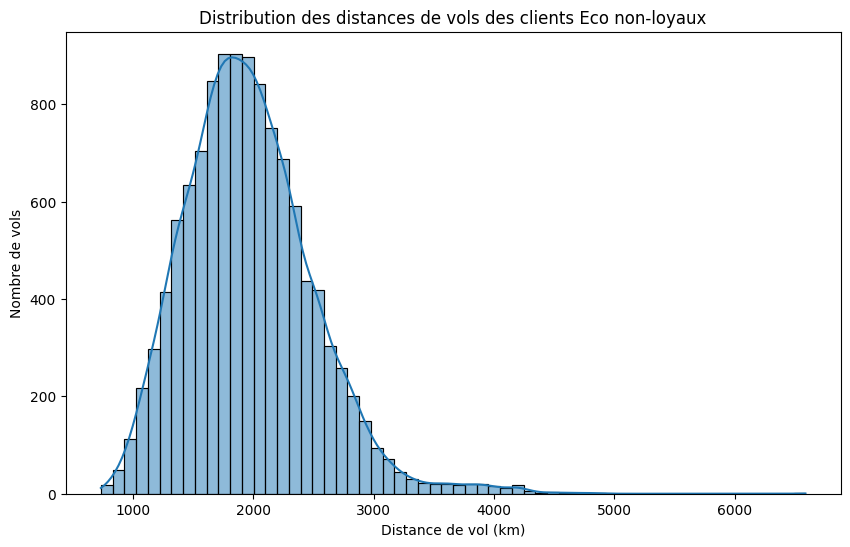

In [194]:
# Sélectionner la colonne des distances de vols et convertir en DataFrame Pandas
filtered_df = df_disloyal_eco.filter((df["Customer Type"] == "disloyal Customer"))
distance_dist = filtered_df.select("Flight Distance").toPandas()

# Afficher l'histogramme de la distribution des distances de vols
plt.figure(figsize=(10, 6))
sns.histplot(distance_dist['Flight Distance'], bins=60, kde=True)
plt.title("Distribution des distances de vols des clients Eco non-loyaux")
plt.xlabel("Distance de vol (km)")
plt.ylabel("Nombre de vols")
plt.show()

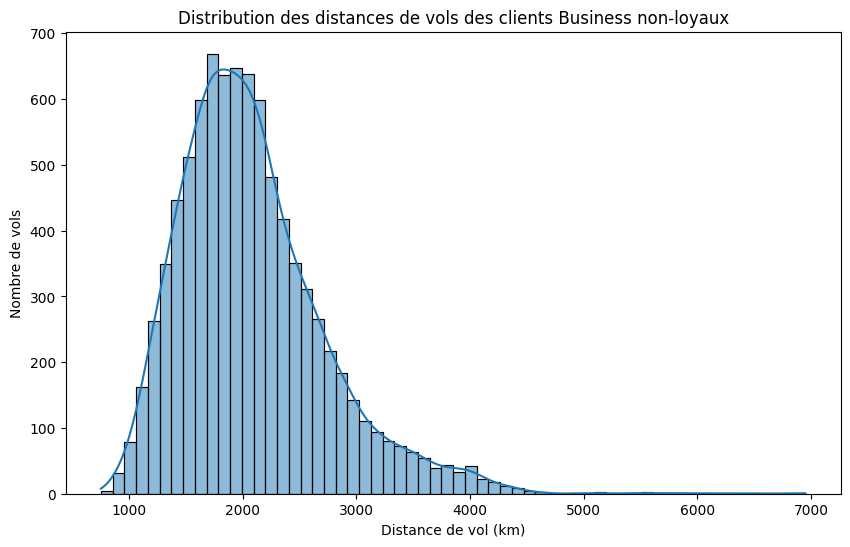

In [195]:
# Sélectionner la colonne des distances de vols et convertir en DataFrame Pandas
filtered_df = df_disloyal_busi.filter((df["Customer Type"] == "disloyal Customer"))
distance_dist = filtered_df.select("Flight Distance").toPandas()

# Afficher l'histogramme de la distribution des distances de vols
plt.figure(figsize=(10, 6))
sns.histplot(distance_dist['Flight Distance'], bins=60, kde=True)
plt.title("Distribution des distances de vols des clients Business non-loyaux")
plt.xlabel("Distance de vol (km)")
plt.ylabel("Nombre de vols")
plt.show()

### On va s'attarder sur les trajets entre 1100km et 3000km

In [204]:
# Filtrer les données pour les distances de vol entre 1100 et 3000 km
df_distance_filtered = df_disloyal.filter(
    (df["Type of Travel"] == "Business travel") & 
    (df['Flight Distance'] >= 1100) & 
    (df['Flight Distance'] <= 3000)
)

/tmp/ipykernel_459181/855396212.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  satisfaction_counts = df_pd.groupby(['Distance Bin', 'satisfaction']).size().unstack(fill_value=0)


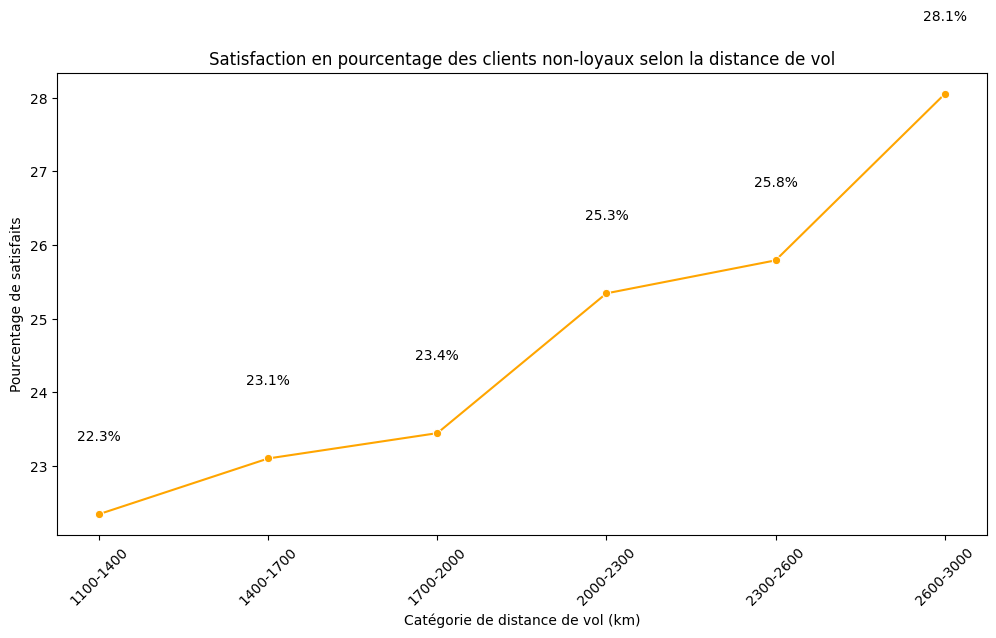

In [209]:
# On garde la distance de vol et la satisfaction
df_pd = df_distance_filtered.select("Flight Distance", "satisfaction").toPandas()

# Supprimer les lignes avec des valeurs manquantes
df_pd.dropna(subset=["Flight Distance", "satisfaction"], inplace=True)

# Créer des bins pour l'histogramme
bins = [1100, 1400, 1700, 2000, 2300, 2600, 3000]
labels = ['1100-1400', '1400-1700', '1700-2000', '2000-2300', '2300-2600', '2600-3000']

# Ajouter une colonne pour les bins de distance de vol
df_pd['Distance Bin'] = pd.cut(df_pd['Flight Distance'], bins=bins, labels=labels)

# Calculer le nombre de clients satisfaits et total dans chaque bin
satisfaction_counts = df_pd.groupby(['Distance Bin', 'satisfaction']).size().unstack(fill_value=0)
total_counts = satisfaction_counts.sum(axis=1)

# Calculer le pourcentage de clients satisfaits dans chaque bin
satisfaction_percentage = (satisfaction_counts['satisfied'] / total_counts) * 100

# Convertir en DataFrame Pandas pour la visualisation
satisfaction_percentage = satisfaction_percentage.reset_index()

# Afficher un graphique en courbe pour visualiser le pourcentage de satisfaits selon la distance de vol
plt.figure(figsize=(12, 6))
sns.lineplot(x='Distance Bin', y=0, data=satisfaction_percentage, marker='o', color='orange')
plt.title("Satisfaction en pourcentage des clients non-loyaux selon la distance de vol")
plt.xlabel("Catégorie de distance de vol (km)")
plt.ylabel("Pourcentage de satisfaits")

# Ajouter les pourcentages au-dessus de chaque point
for i in range(len(satisfaction_percentage)):
    plt.text(i, satisfaction_percentage[0][i] + 1, f'{satisfaction_percentage[0][i]:.1f}%', ha='center', color='black')

plt.xticks(rotation=45)
plt.show()

### 6.6 **Satisfaction** par paramètre selon la **distance de vol**

/tmp/ipykernel_459181/3821155581.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_satisfied = df_satisfied_pd.groupby('Distance Bin')[params].mean().reset_index()
/tmp/ipykernel_459181/3821155581.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_dissatisfied = df_dissatisfied_pd.groupby('Distance Bin')[params].mean().reset_index()


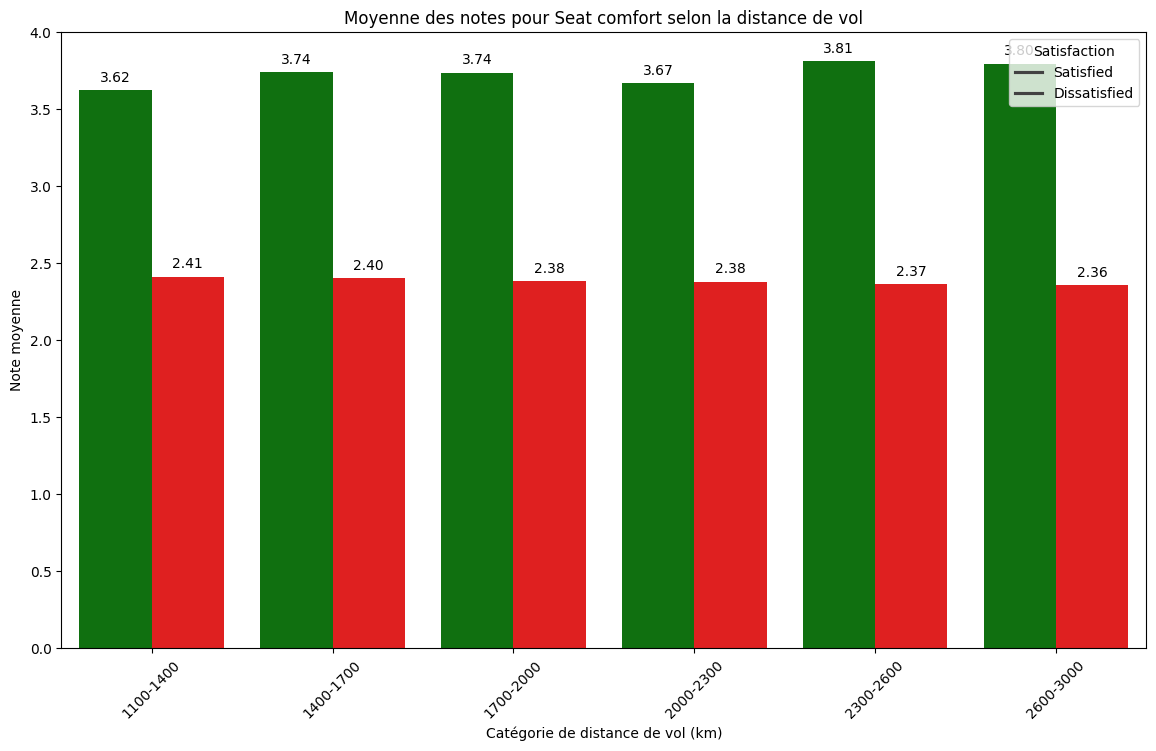

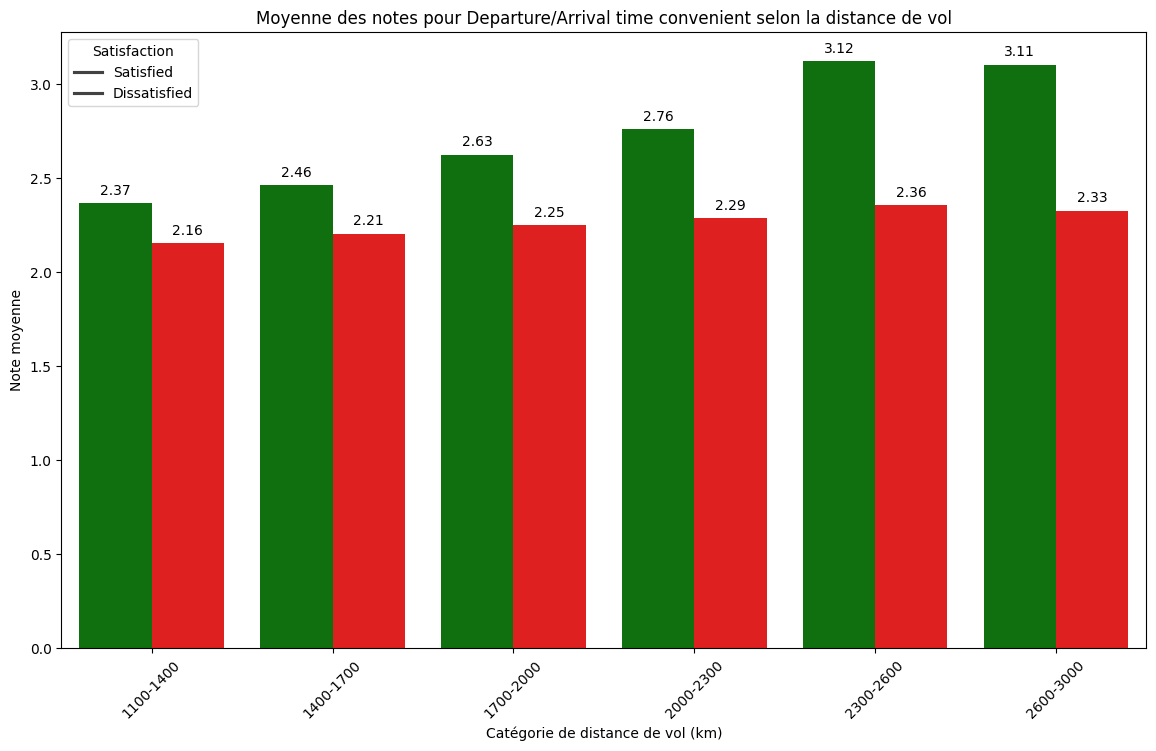

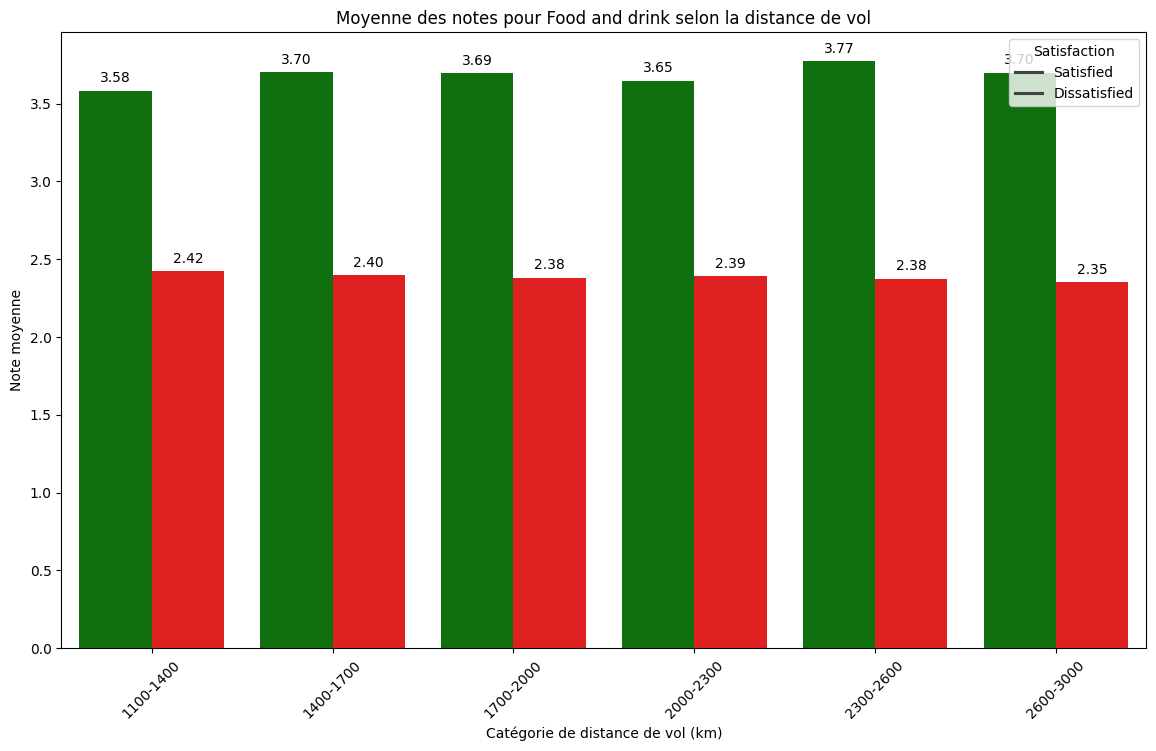

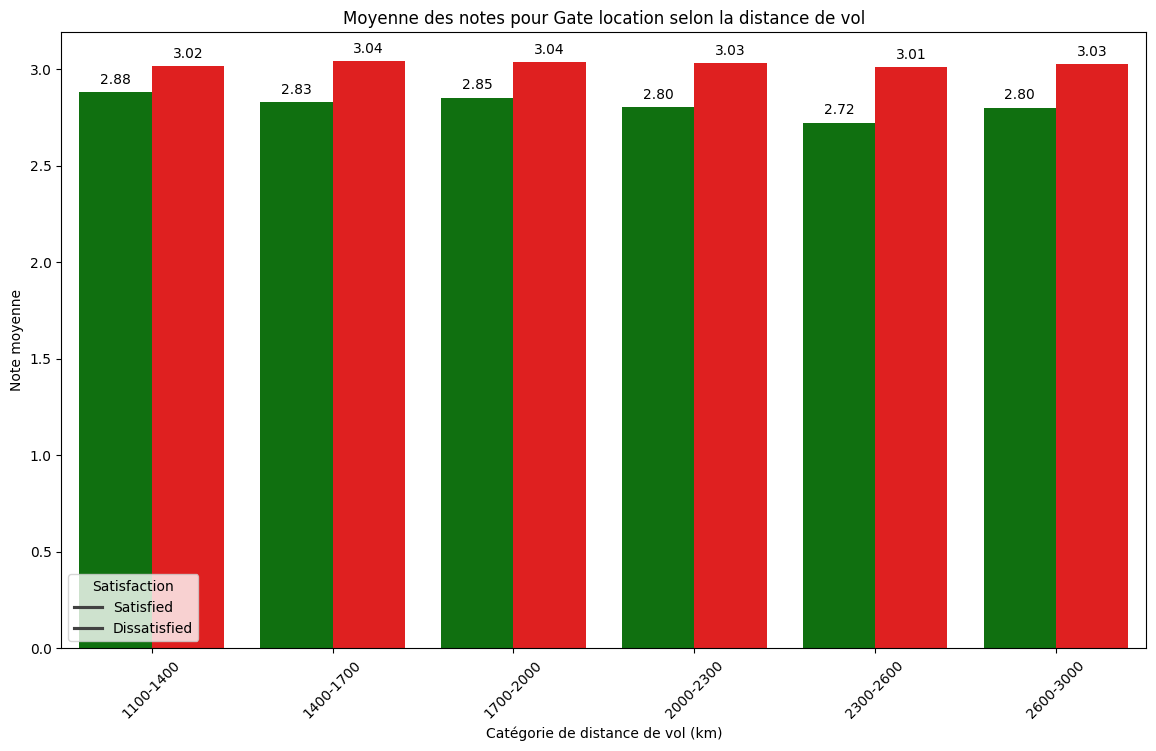

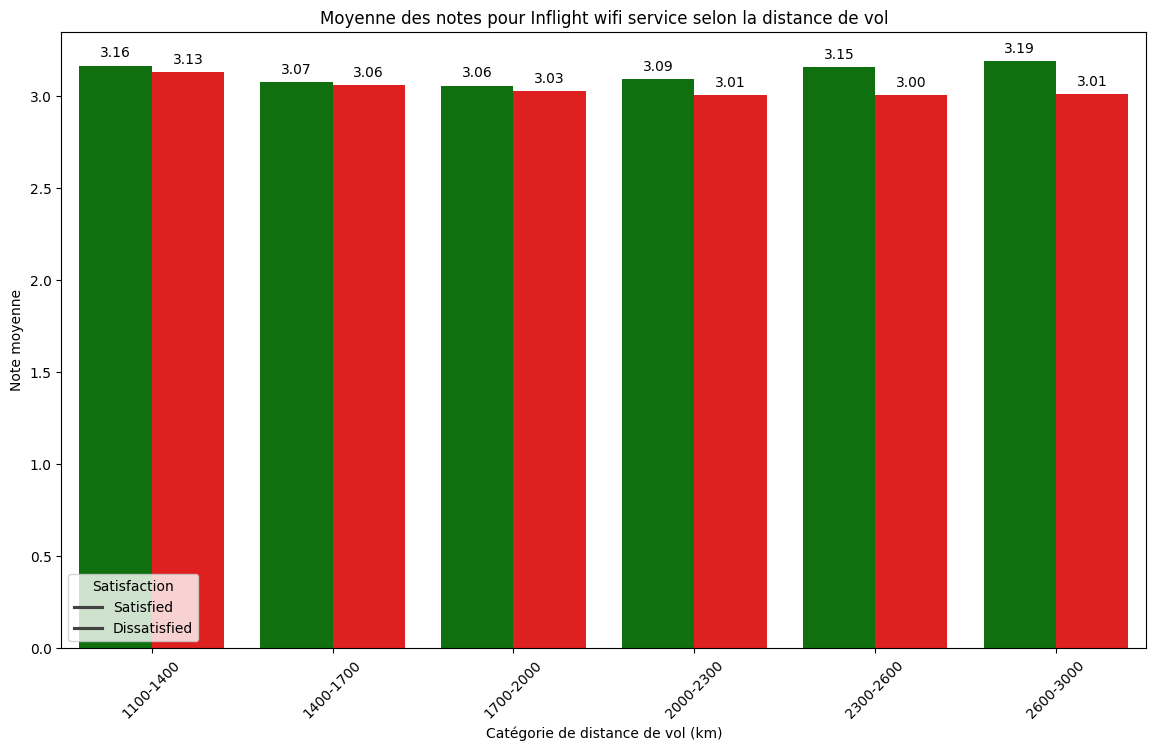

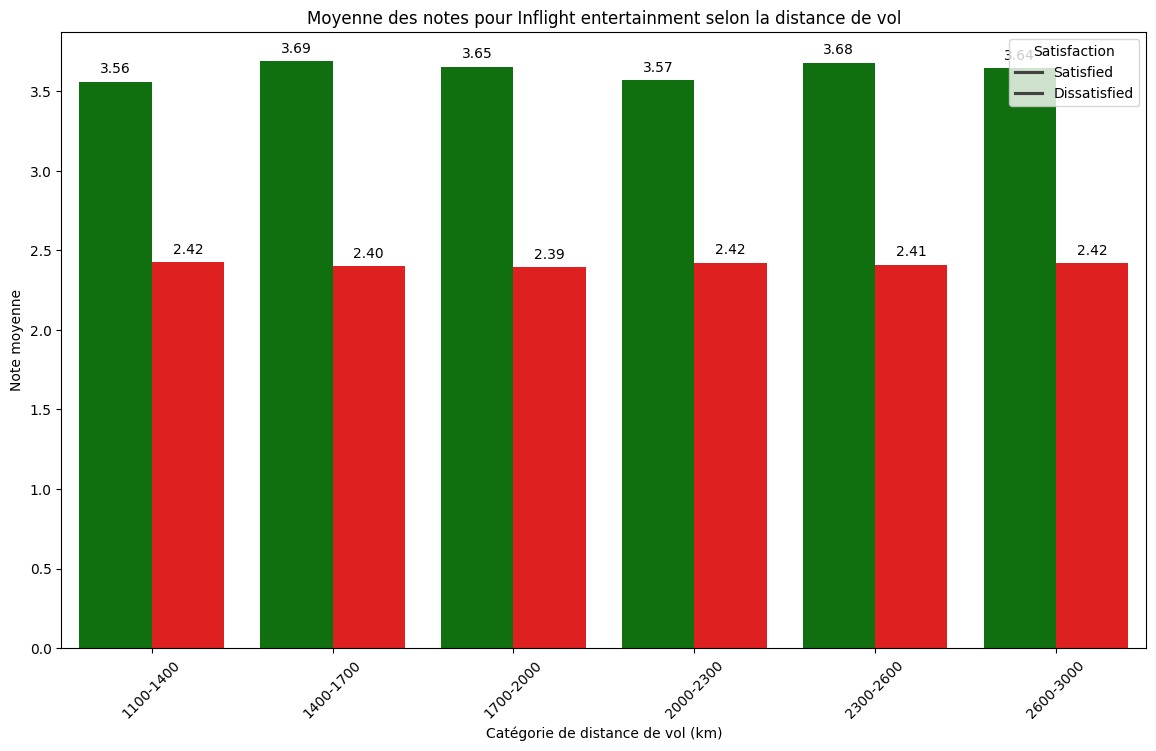

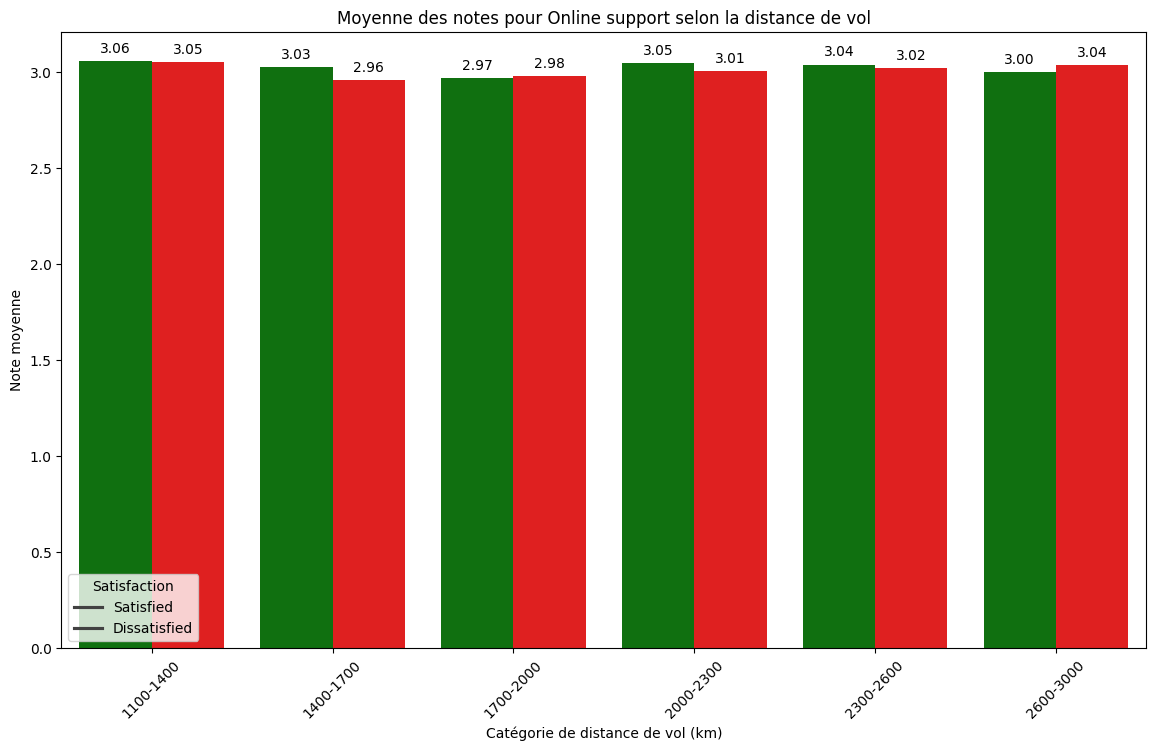

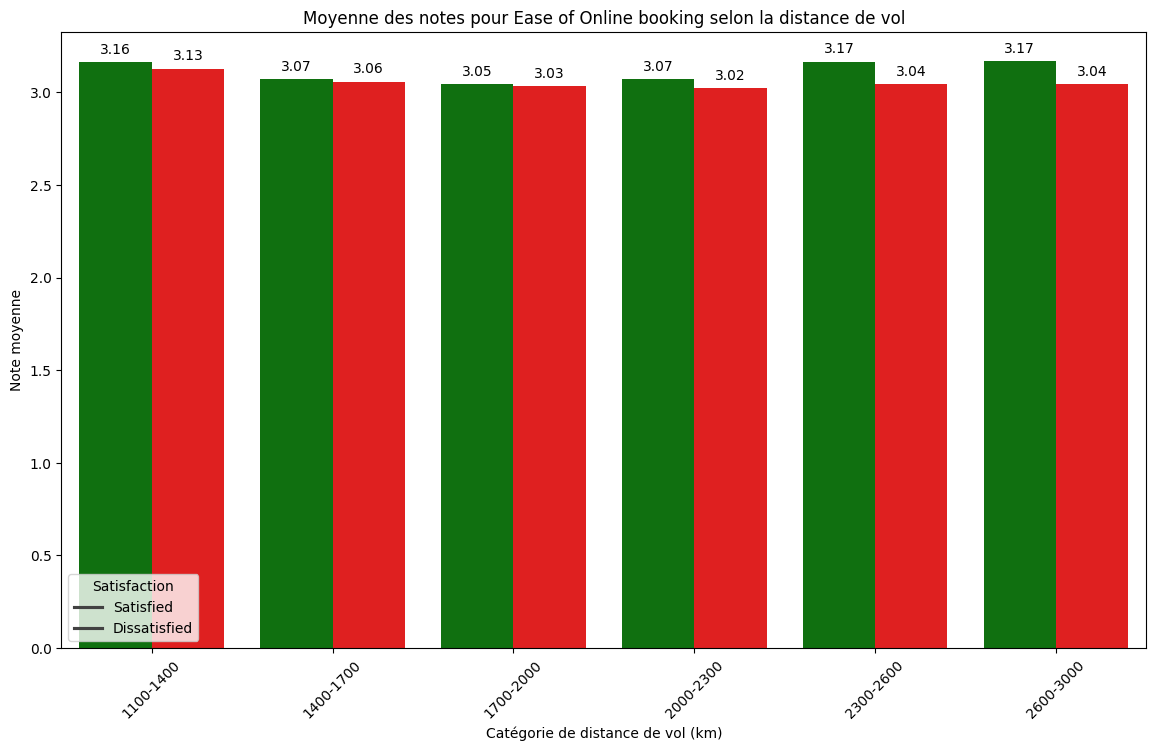

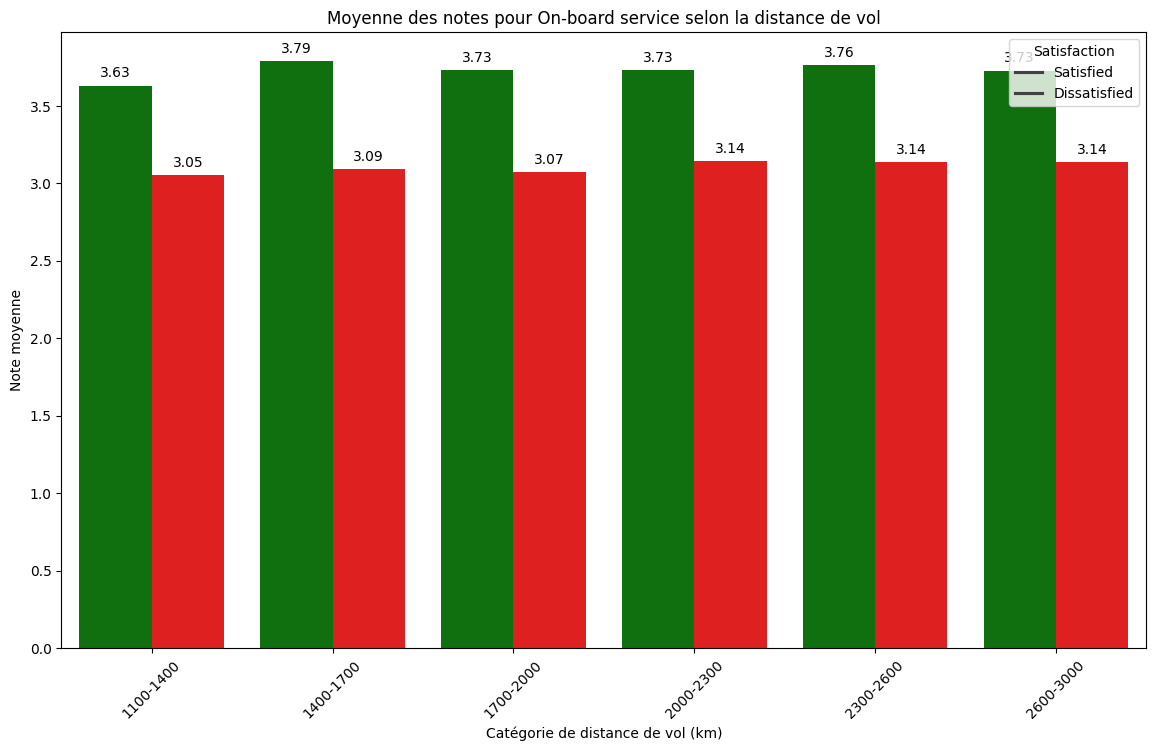

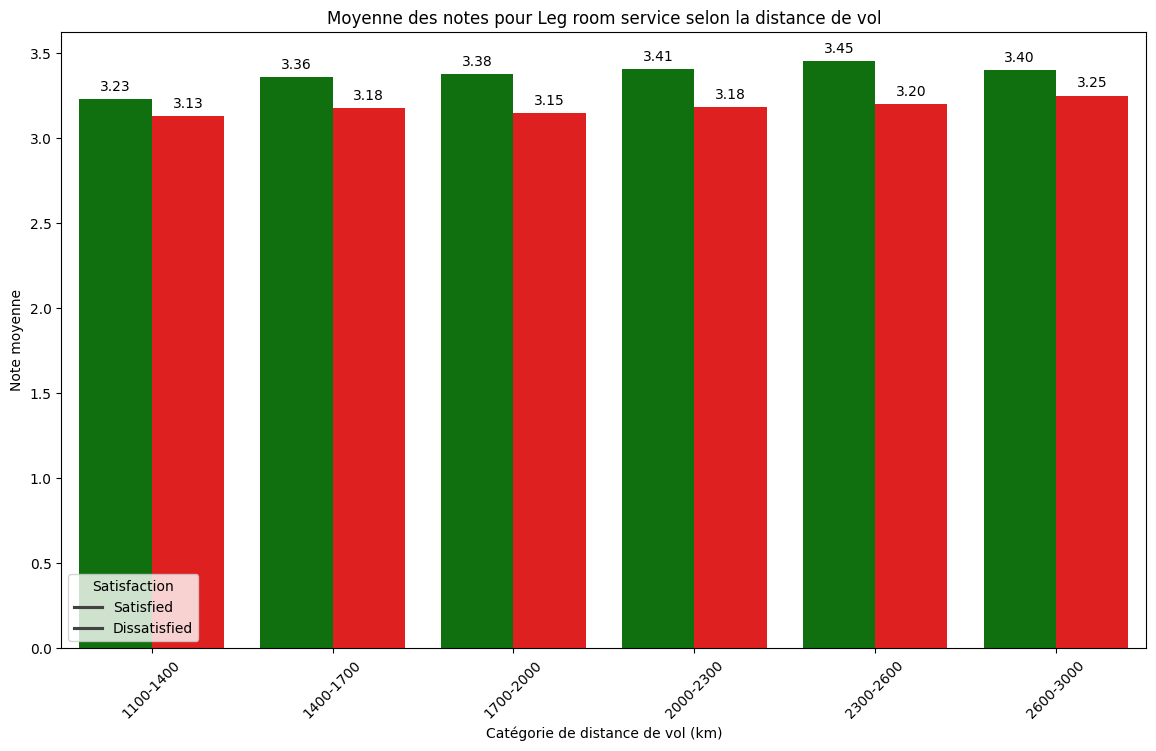

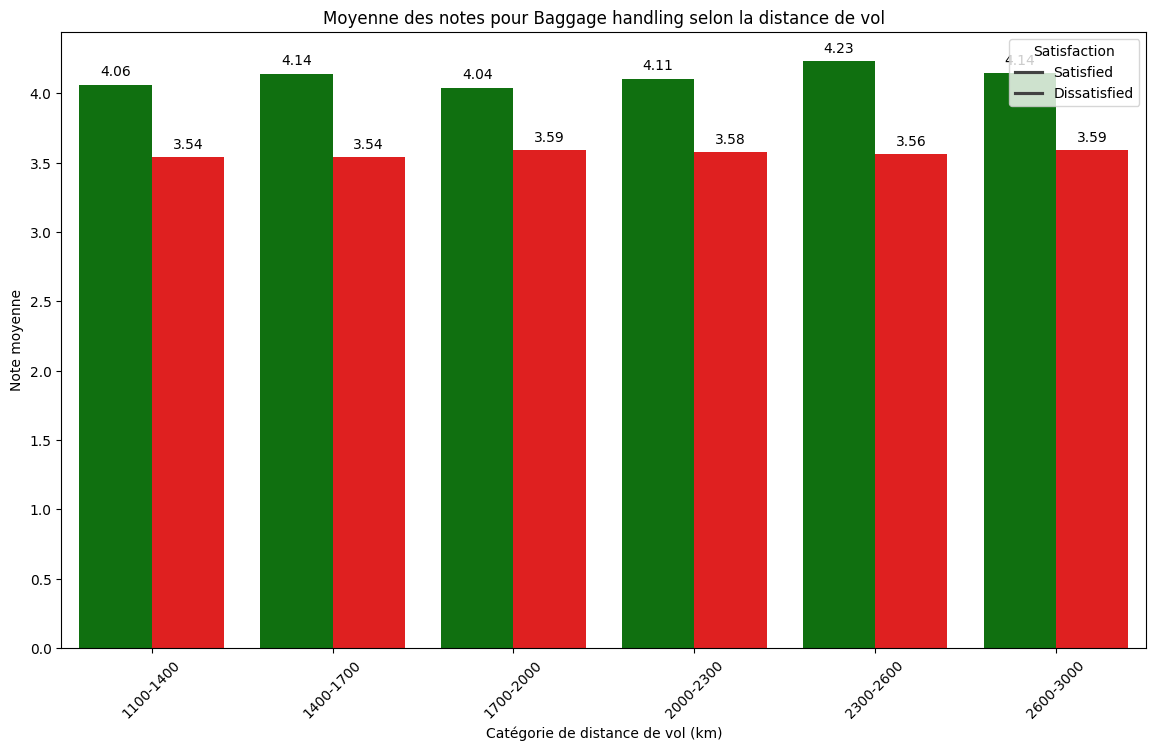

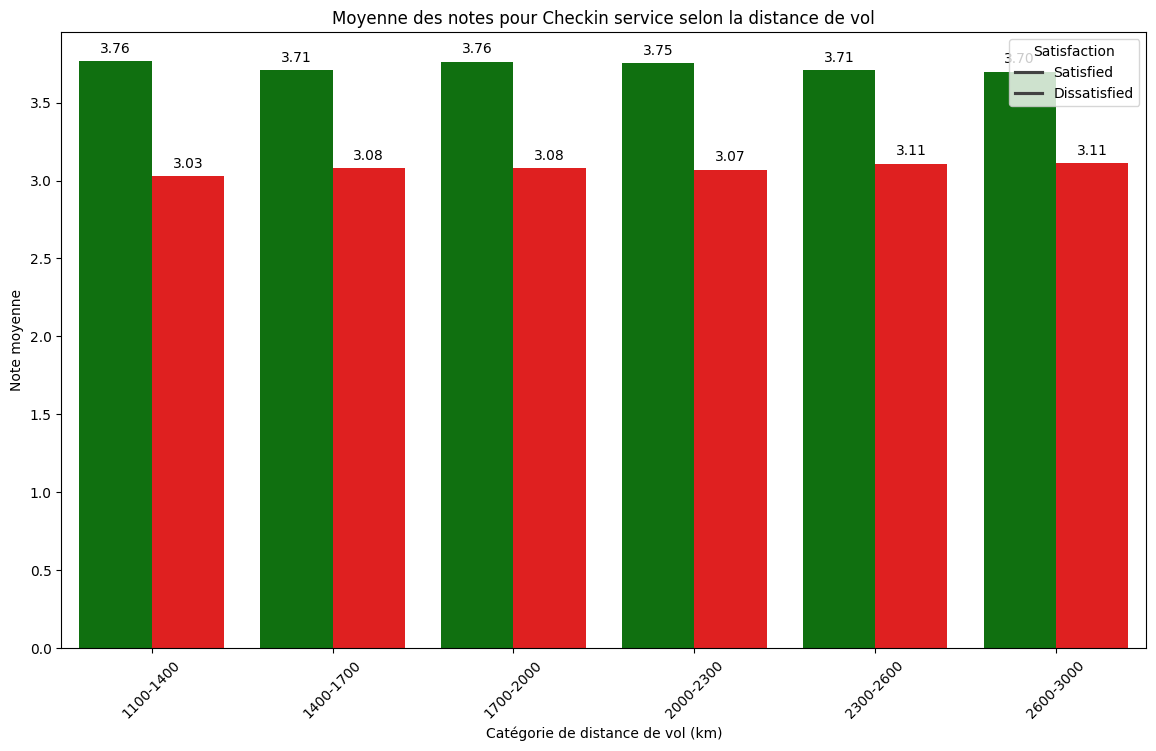

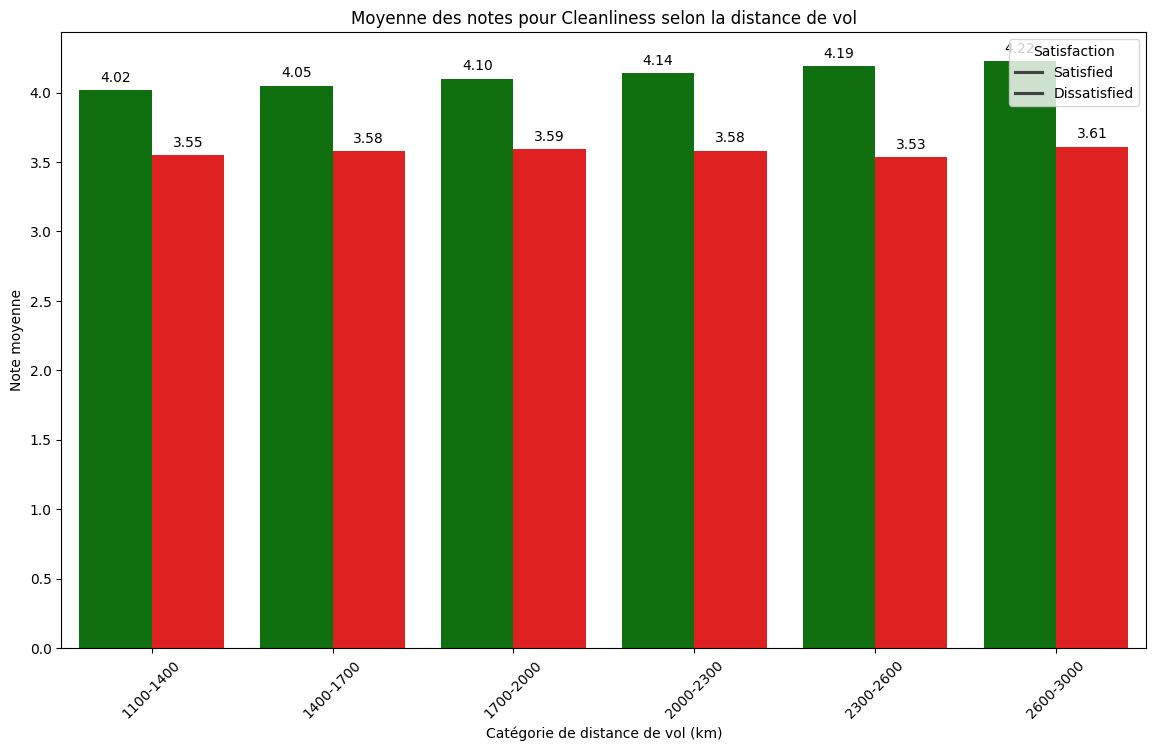

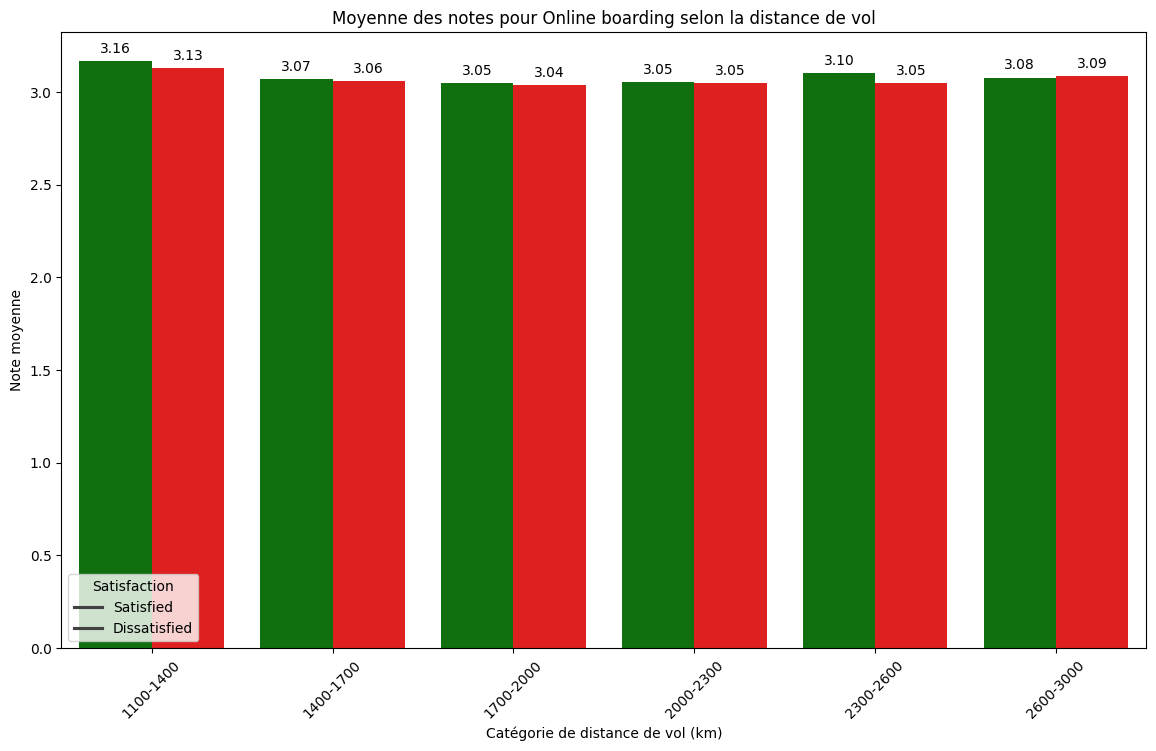

In [210]:
# Convertir en DataFrame Pandas pour faciliter la manipulation
df_disloyal_pd = df_distance_filtered.select(
    "Flight Distance", "satisfaction", "Seat comfort", "Departure/Arrival time convenient", 
    "Food and drink", "Gate location", "Inflight wifi service", "Inflight entertainment", 
    "Online support", "Ease of Online booking", "On-board service", "Leg room service", 
    "Baggage handling", "Checkin service", "Cleanliness", "Online boarding").toPandas()

# Supprimer les lignes avec des valeurs manquantes
df_disloyal_pd.dropna(subset=["Flight Distance", "satisfaction"], inplace=True)

# Créer des bins pour l'histogramme
bins = [1100, 1400, 1700, 2000, 2300, 2600, 3000]
labels = ['1100-1400', '1400-1700', '1700-2000', '2000-2300', '2300-2600', '2600-3000']
df_disloyal_pd['Distance Bin'] = pd.cut(
    df_disloyal_pd['Flight Distance'],
    bins=bins,
    labels=labels,
    right=False
)

# Séparer les clients satisfaits et insatisfaits
df_satisfied_pd = df_disloyal_pd[df_disloyal_pd['satisfaction'] == 'satisfied']
df_dissatisfied_pd = df_disloyal_pd[df_disloyal_pd['satisfaction'] == 'dissatisfied']

# Calculer les notes moyennes pour chaque paramètre et chaque bin
params = [
    "Seat comfort", "Departure/Arrival time convenient", "Food and drink", "Gate location", 
    "Inflight wifi service", "Inflight entertainment", "Online support", "Ease of Online booking", 
    "On-board service", "Leg room service", "Baggage handling", "Checkin service", "Cleanliness", 
    "Online boarding"
]

avg_satisfied = df_satisfied_pd.groupby('Distance Bin')[params].mean().reset_index()
avg_dissatisfied = df_dissatisfied_pd.groupby('Distance Bin')[params].mean().reset_index()
# Fusionner les deux DataFrames pour comparaison
avg_scores = pd.merge(
    avg_satisfied,
    avg_dissatisfied,
    on='Distance Bin',
    suffixes=('_satisfied', '_dissatisfied')
)

# Afficher les résultats
for param in params:
    plt.figure(figsize=(14, 8))
    avg_scores_melted = avg_scores.melt(
        id_vars='Distance Bin', 
        value_vars=[f'{param}_satisfied', f'{param}_dissatisfied'],
        var_name='Satisfaction',
        value_name='Average Score'
    )
    ax = sns.barplot(
        x='Distance Bin',
        y='Average Score',
        hue='Satisfaction',
        data=avg_scores_melted,
        palette=['green', 'red']
    )
    plt.title(f"Moyenne des notes pour {param} selon la distance de vol")
    plt.xlabel("Catégorie de distance de vol (km)")
    plt.ylabel("Note moyenne")
    plt.legend(title='Satisfaction', labels=['Satisfied', 'Dissatisfied'])
    plt.xticks(rotation=45)

    # Ajouter les moyennes au-dessus des barres
    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(
                format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points'
            )

    plt.show()

In [8]:
df.toPandas()

satisfaction      Customer Type  Age   Type of Travel     Class  \
0          satisfied     Loyal Customer   65  Personal Travel       Eco   
1          satisfied     Loyal Customer   47  Personal Travel  Business   
2          satisfied     Loyal Customer   15  Personal Travel       Eco   
3          satisfied     Loyal Customer   60  Personal Travel       Eco   
4          satisfied     Loyal Customer   70  Personal Travel       Eco   
...              ...                ...  ...              ...       ...   
129875     satisfied  disloyal Customer   29  Personal Travel       Eco   
129876  dissatisfied  disloyal Customer   63  Personal Travel  Business   
129877  dissatisfied  disloyal Customer   69  Personal Travel       Eco   
129878  dissatisfied  disloyal Customer   66  Personal Travel       Eco   
129879  dissatisfied  disloyal Customer   38  Personal Travel       Eco   

        Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0                   265             0                                  0   
1                  2464             0                                  0   
2                  2138             0                                  0   
3                   623             0                                  0   
4                   354             0                                  0   
...                 ...           ...                                ...   
129875             1731             5                                  5   
129876             2087             2                                  3   
129877             2320             3                                  0   
129878             2450             3                                  2   
129879             4307             3                                  4   

        Food and drink  Gate location  ...  Online support  \
0                    0              2  ...               2   
1                    0              3  ...               2   
2                    0              3  ...               2   
3                    0              3  ...               3   
4                    0              3  ...               4   
...                ...            ...  ...             ...   
129875               5              3  ...               2   
129876               2              4  ...               1   
129877               3              3  ...               2   
129878               3              2  ...               2   
129879               3              3  ...               3   

        Ease of Online booking  On-board service  Leg room service  \
0                            3                 3                 0   
1                            3                 4                 4   
2                            2                 3                 3   
3                            1                 1                 0   
4                            2                 2                 0   
...                        ...               ...               ...   
129875                       2                 3                 3   
129876                       3                 2                 3   
129877                       4                 4                 3   
129878                       3                 3                 2   
129879                       4                 5                 5   

        Baggage handling  Checkin service  Cleanliness  Online boarding  \
0                      3                5            3                2   
1                      4                2            3                2   
2                      4                4            4                2   
3                      1                4            1                3   
4                      2                4            2                5   
...                  ...              ...          ...              ...   
129875                 4                4            4                2   
129876  

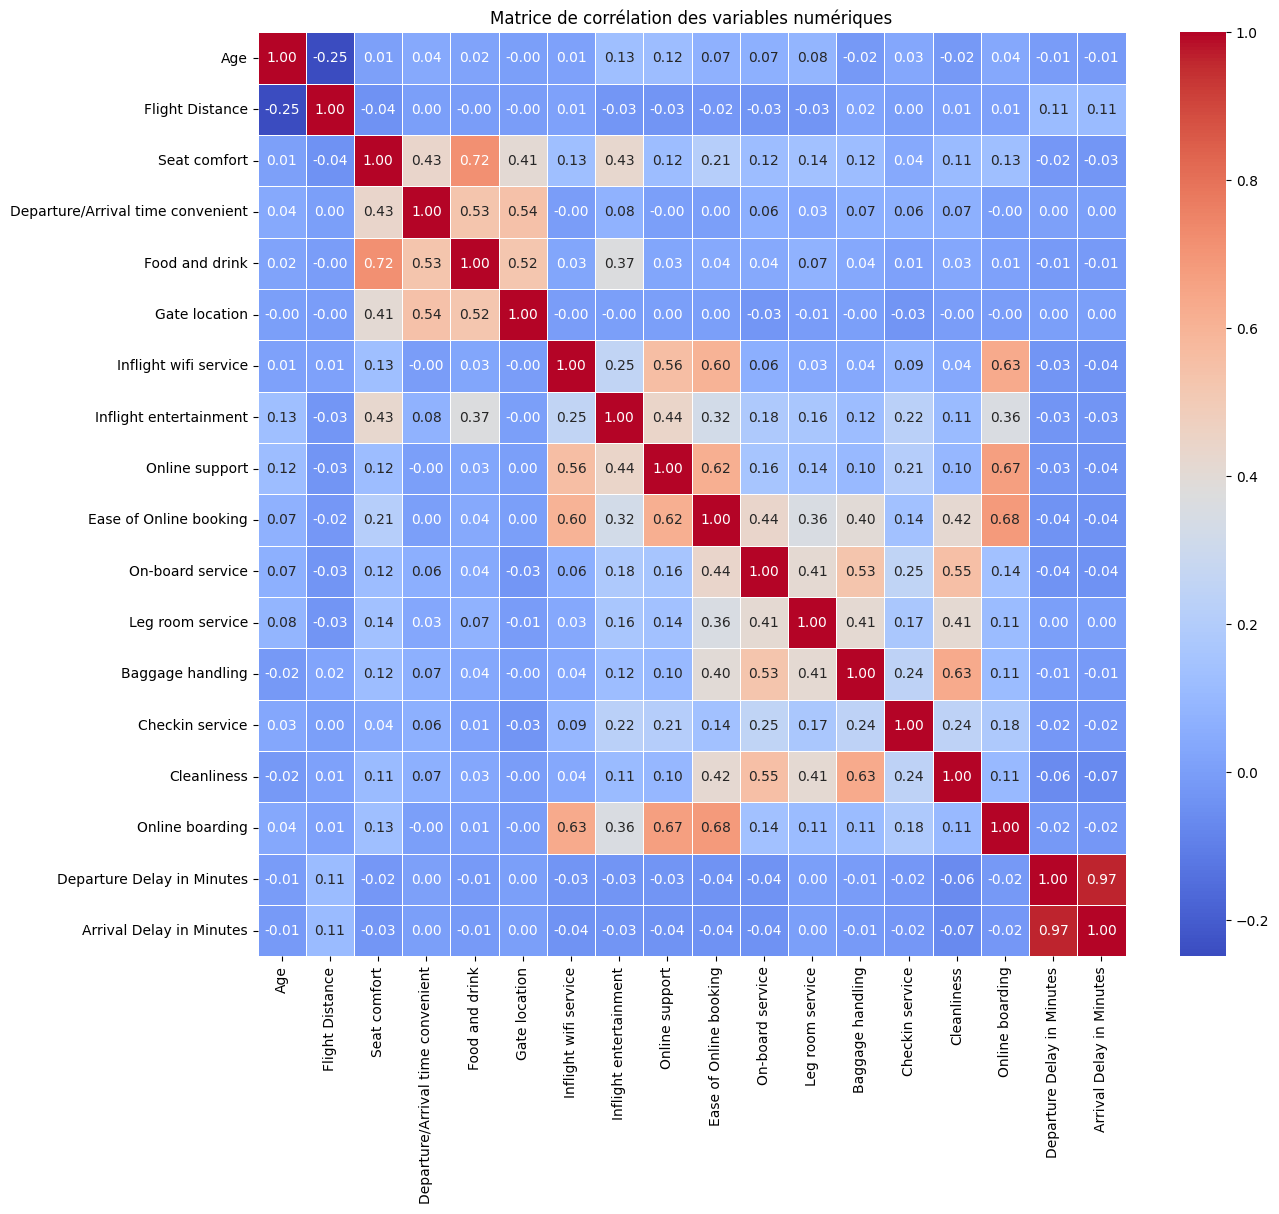

In [21]:
# Convertir le DataFrame Spark en DataFrame Pandas pour la matrice de corrélation
df_pd = df.select(numeric_cols).toPandas()

# Calculer la matrice de corrélation
correlation_matrix = df_pd.corr()

# Afficher la matrice de corrélation avec seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de corrélation des variables numériques')
plt.show()

## Modèle

In [44]:
df_pd.head()

satisfaction   Customer Type  Age   Type of Travel     Class  \
0             0  Loyal Customer   65  Personal Travel       Eco   
1             0  Loyal Customer   47  Personal Travel  Business   
2             0  Loyal Customer   15  Personal Travel       Eco   
3             0  Loyal Customer   60  Personal Travel       Eco   
4             0  Loyal Customer   70  Personal Travel       Eco   

   Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0              265             0                                  0   
1             2464             0                                  0   
2             2138             0                                  0   
3              623             0                                  0   
4              354             0                                  0   

   Food and drink  Gate location  ...  Online support  Ease of Online booking  \
0               0              2  ...               2                       3   
1               0              3  ...               2                       3   
2               0              3  ...               2                       2   
3               0              3  ...               3                       1   
4               0              3  ...               4                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 3                 0                 3                5   
1                 4                 4                 4                2   
2                 3                 3                 4                4   
3                 1                 0                 1                4   
4                 2                 0                 2                4   

   Cleanliness  Online boarding  Departure Delay in Minutes  \
0            3                2                           0   
1            3                2                         310   
2            4                2                           0   
3            1                3                           0   
4            2                5                           0   

   Arrival Delay in Minutes  
0                       0.0  
1                     305.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 22 columns]

In [47]:
df_pd.columns

Index(['satisfaction', 'Age', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Customer Type_disloyal Customer', 'Type of Travel_Personal Travel',
       'Class_Eco', 'Class_Eco Plus'],
      dtype='object')

In [53]:
df_pd

satisfaction      Customer Type  Age   Type of Travel     Class  \
0          satisfied     Loyal Customer   65  Personal Travel       Eco   
1          satisfied     Loyal Customer   47  Personal Travel  Business   
2          satisfied     Loyal Customer   15  Personal Travel       Eco   
3          satisfied     Loyal Customer   60  Personal Travel       Eco   
4          satisfied     Loyal Customer   70  Personal Travel       Eco   
...              ...                ...  ...              ...       ...   
129875     satisfied  disloyal Customer   29  Personal Travel       Eco   
129876  dissatisfied  disloyal Customer   63  Personal Travel  Business   
129877  dissatisfied  disloyal Customer   69  Personal Travel       Eco   
129878  dissatisfied  disloyal Customer   66  Personal Travel       Eco   
129879  dissatisfied  disloyal Customer   38  Personal Travel       Eco   

        Flight Distance  Seat comfort  Departure/Arrival time convenient  \
0                   265             0                                  0   
1                  2464             0                                  0   
2                  2138             0                                  0   
3                   623             0                                  0   
4                   354             0                                  0   
...                 ...           ...                                ...   
129875             1731             5                                  5   
129876             2087             2                                  3   
129877             2320             3                                  0   
129878             2450             3                                  2   
129879             4307             3                                  4   

        Food and drink  Gate location  ...  Online support  \
0                    0              2  ...               2   
1                    0              3  ...               2   
2                    0              3  ...               2   
3                    0              3  ...               3   
4                    0              3  ...               4   
...                ...            ...  ...             ...   
129875               5              3  ...               2   
129876               2              4  ...               1   
129877               3              3  ...               2   
129878               3              2  ...               2   
129879               3              3  ...               3   

        Ease of Online booking  On-board service  Leg room service  \
0                            3                 3                 0   
1                            3                 4                 4   
2                            2                 3                 3   
3                            1                 1                 0   
4                            2                 2                 0   
...                        ...               ...               ...   
129875                       2                 3                 3   
129876                       3                 2                 3   
129877                       4                 4                 3   
129878                       3                 3                 2   
129879                       4                 5                 5   

        Baggage handling  Checkin service  Cleanliness  Online boarding  \
0                      3                5            3                2   
1                      4                2            3                2   
2                      4                4            4                2   
3                      1                4            1                3   
4                      2                4            2                5   
...                  ...              ...          ...              ...   
129875                 4                4            4                2   
129876  

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

categorical_columns = ['Customer Type', 'Type of Travel', 'Class']
df_transformed = pd.get_dummies(df_pd, columns=categorical_columns, drop_first=True).dropna()

X = df_transformed.drop('satisfaction', axis=1)
y = df_transformed['satisfaction']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8294076762684377
Confusion Matrix:
[[ 9590  2231]
 [ 2187 11890]]
Classification Report:
              precision    recall  f1-score   support

dissatisfied       0.81      0.81      0.81     11821
   satisfied       0.84      0.84      0.84     14077

    accuracy                           0.83     25898
   macro avg       0.83      0.83      0.83     25898
weighted avg       0.83      0.83      0.83     25898



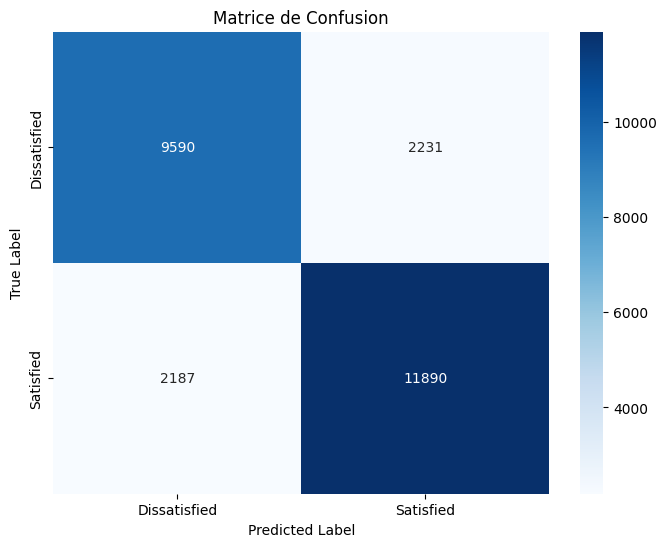

In [63]:
# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['Dissatisfied', 'Satisfied'], yticklabels=['Dissatisfied', 'Satisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de Confusion')
plt.show()

In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.9171750714340876
KNN Confusion Matrix:
[[11329   492]
 [ 1653 12424]]
KNN Classification Report:
              precision    recall  f1-score   support

dissatisfied       0.87      0.96      0.91     11821
   satisfied       0.96      0.88      0.92     14077

    accuracy                           0.92     25898
   macro avg       0.92      0.92      0.92     25898
weighted avg       0.92      0.92      0.92     25898



In [1]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

ModuleNotFoundError: No module named 'sklearn'

In [2]:
import cv2
import numpy as np

def capture_image():
    # Ouvrir la caméra
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Erreur : Impossible d'ouvrir la caméra.")
        return None

    while True:
        # Capturer une frame
        ret, frame = cap.read()

        if not ret:
            print("Erreur : Impossible de lire la frame.")
            break

        # Afficher la frame capturée
        cv2.imshow('Capture d\'image', frame)

        # Attendre l'appui sur la touche 'c' pour capturer l'image caca
        if cv2.waitKey(1) & 0xFF == ord('c'):
            break

    # Libérer la caméra et fermer les fenêtres
    cap.release()
    cv2.destroyAllWindows()

    # Retourner le tableau numpy des pixels de l'image
    return frame

image_array = capture_image()
if image_array is not None:
    print("Image capturée avec succès.")
    print("Dimensions de l'image : ", image_array.shape)
    # Afficher quelques pixels pour vérifier
    print("Quelques pixels de l'image :\n", image_array[:5, :5])

Erreur : Impossible d'ouvrir la caméra.


[ WARN:0@0.159] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@0.161] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
